In [ ]:
!pip install transformers
!pip install torchdata
!pip install -U torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import random
import torch
import numpy as np
from torch.utils.data.dataset import ConcatDataset
from torchtext.datasets import RTE,MRPC
torch.manual_seed(2022)
random.seed(2022)

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, MSELoss
from transformers import BertPreTrainedModel, BertModel,BertConfig
class BertForSequenceClassification(BertPreTrainedModel):
    def __init__(self,config):
        super().__init__(config)
        self.num_labels = 2
        #config = BertConfig()
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(0.2)
        self.deterministic = False
        self.ib_dim = 384
        self.ib = True
        #self.deterministic = True
        self.activation = 'relu'
        self.activations = {'tanh': nn.Tanh(), 'relu': nn.ReLU(), 'sigmoid': nn.Sigmoid()}
        if self.ib or self.deterministic:
            self.kl_annealing = "linear"
            self.hidden_dim = (768 + self.ib_dim) // 2
            intermediate_dim = (self.hidden_dim+768)//2
            self.mlp_rte = nn.Sequential(
                nn.Linear(768, intermediate_dim), #768
                self.activations[self.activation],
                nn.Linear(intermediate_dim, self.hidden_dim),
                self.activations[self.activation])
            self.mlp_mrpc = nn.Sequential(
                nn.Linear(768, intermediate_dim), #768
                self.activations[self.activation],
                nn.Linear(intermediate_dim, self.hidden_dim),
                self.activations[self.activation])
            self.beta = 1e-03
            self.sample_size = 10 #5 
            self.emb2mu_rte = nn.Linear(self.hidden_dim, self.ib_dim)
            self.emb2std_rte = nn.Linear(self.hidden_dim, self.ib_dim)
            self.mu_p_rte = nn.Parameter(torch.randn(self.ib_dim))
            self.std_p_rte = nn.Parameter(torch.randn(self.ib_dim))
            self.emb2mu_mrpc = nn.Linear(self.hidden_dim, self.ib_dim)
            self.emb2std_mrpc = nn.Linear(self.hidden_dim, self.ib_dim)
            self.mu_p_mrpc = nn.Parameter(torch.randn(self.ib_dim))
            self.std_p_mrpc = nn.Parameter(torch.randn(self.ib_dim))
            self.classifier_rte = nn.Linear(self.ib_dim, self.num_labels)
            self.classifier_mrpc = nn.Linear(self.ib_dim, self.num_labels) 
        else:
            self.classifier = nn.Linear(768, self.num_labels)

        self.init_weights()

    def estimate(self, emb, emb2mu, emb2std):
        """Estimates mu and std from the given input embeddings."""
        mean = emb2mu(emb)
        std = torch.nn.functional.softplus(emb2std(emb))
        return mean, std

    def kl_div(self, mu_q, std_q, mu_p, std_p):
        """Computes the KL divergence between the two given variational distribution.\
           This computes KL(q||p), which is not symmetric. It quantifies how far is\
           The estimated distribution q from the true distribution of p."""
        k = mu_q.size(1)
        mu_diff = mu_p - mu_q
        mu_diff_sq = torch.mul(mu_diff, mu_diff)
        logdet_std_q = torch.sum(2 * torch.log(torch.clamp(std_q, min=1e-8)), dim=1)
        logdet_std_p = torch.sum(2 * torch.log(torch.clamp(std_p, min=1e-8)), dim=1)
        fs = torch.sum(torch.div(std_q ** 2, std_p ** 2), dim=1) + torch.sum(torch.div(mu_diff_sq, std_p ** 2), dim=1)
        kl_divergence = (fs - k + logdet_std_p - logdet_std_q)*0.5
        return kl_divergence.mean()

    def reparameterize(self, mu, std):
        batch_size = mu.shape[0]
        z = torch.randn(self.sample_size, batch_size, mu.shape[1]).cuda()
        return mu + std * z

    def get_logits(self, z, mu, sampling_type,dataset_name):
        if sampling_type == "iid":
            if dataset_name == "rte":
              logits = self.classifier_rte(z)
            else:
              logits = self.classifier_mrpc(z)
            mean_logits = logits.mean(dim=0)
            logits = logits.permute(1, 2, 0)
        else:
            if dataset_name == 0:
              mean_logits = self.classifier_rte(mu)
            else:
              mean_logits = self.classifier_mrpc(mu)
            #mean_logits = self.classifier(mu)
            logits = mean_logits
        return logits, mean_logits


    def sampled_loss(self, logits, mean_logits, labels, sampling_type):
        if sampling_type == "iid":
            # During the training, computes the loss with the sampled embeddings.
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.sample_size), labels[:, None].float().expand(-1, self.sample_size))
                loss = torch.mean(loss, dim=-1)
                loss = torch.mean(loss, dim=0)
            else:
                loss_fct = CrossEntropyLoss(reduce=False)
                loss = loss_fct(logits, labels[:, None].expand(-1, self.sample_size))
                loss = torch.mean(loss, dim=-1)
                loss = torch.mean(loss, dim=0)
        else:
            # During test time, uses the average value for prediction.
            if self.num_labels == 1:
                loss_fct = MSELoss()
                loss = loss_fct(mean_logits.view(-1), labels.float().view(-1))
            else:
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(mean_logits, labels)
        return loss

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        sampling_type="iid",
        epoch=1,
        **kwargs
        #dataset_name="rte",
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`, defaults to :obj:`None`):
            Labels for computing the sequence classification/regression loss.
            Indices should be in :obj:`[0, ..., config.num_labels - 1]`.
            If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
            If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).
    Returns:
        :obj:`tuple(torch.FloatTensor)` comprising various elements depending on the configuration (:class:`~transformers.BertConfig`) and inputs:
        loss (:obj:`torch.FloatTensor` of shape :obj:`(1,)`, `optional`, returned when :obj:`label` is provided):
            Classification (or regression if config.num_labels==1) loss.
        logits (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, config.num_labels)`):
            Classification (or regression if config.num_labels==1) scores (before SoftMax).
        hidden_states (:obj:`tuple(torch.FloatTensor)`, `optional`, returned when ``config.output_hidden_states=True``):
            Tuple of :obj:`torch.FloatTensor` (one for the output of the embeddings + one for the output of each layer)
            of shape :obj:`(batch_size, sequence_length, hidden_size)`.
            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        attentions (:obj:`tuple(torch.FloatTensor)`, `optional`, returned when ``config.output_attentions=True``):
            Tuple of :obj:`torch.FloatTensor` (one for each layer) of shape
            :obj:`(batch_size, num_heads, sequence_length, sequence_length)`.
            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention
            heads.
    Examples::
        from transformers import BertTokenizer, BertForSequenceClassification
        import torch
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
        input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
        labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
        outputs = model(input_ids, labels=labels)
        loss, logits = outputs[:2]
        """
        #dataset_name="rte"
        #print(position_ids.item())
        position_id = None
        final_outputs = {}
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_id,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        loss = {}

        if self.deterministic:
            pooled_output = self.mlp(pooled_output)
            mu, std = self.estimate(pooled_output, self.emb2mu, self.emb2std)
            final_outputs["z"] = mu
            sampled_logits, logits = self.get_logits(mu, mu, sampling_type='argmax',dataset_name=kwargs["dataset_name"]) # always deterministic
            if labels is not None:
                loss["loss"] = self.sampled_loss(sampled_logits, logits, labels.view(-1), sampling_type='argmax')

        elif self.ib:
            if kwargs["dataset_name"]=="rte":
              pooled_output = self.mlp_rte(pooled_output)
              batch_size = pooled_output.shape[0]
              mu, std = self.estimate(pooled_output, self.emb2mu_rte, self.emb2std_rte)
              mu_p = self.mu_p_rte.view(1, -1).expand(batch_size, -1)
              std_p = torch.nn.functional.softplus(self.std_p_rte.view(1, -1).expand(batch_size, -1))
            else:
              pooled_output = self.mlp_mrpc(pooled_output)
              batch_size = pooled_output.shape[0]
              mu, std = self.estimate(pooled_output, self.emb2mu_mrpc, self.emb2std_mrpc)
              mu_p = self.mu_p_mrpc.view(1, -1).expand(batch_size, -1)
              std_p = torch.nn.functional.softplus(self.std_p_mrpc.view(1, -1).expand(batch_size, -1))
            kl_loss = self.kl_div(mu, std, mu_p, std_p)
            z = self.reparameterize(mu, std)
            final_outputs["z"] = mu

            if self.kl_annealing == "linear":
                beta = min(1.0, epoch*self.beta)
                 
            sampled_logits, logits = self.get_logits(z, mu, sampling_type,dataset_name=kwargs["dataset_name"])
            #print(labels)
            if labels is not None:
                if kwargs["label"] is not None:
                  ce_loss_rte = self.sampled_loss(kwargs["sampled_logits"], kwargs["logits"], kwargs["label"].view(-1), sampling_type)
                  total_loss_rte = ce_loss_rte + (beta if self.kl_annealing == "linear" else self.beta) * kwargs["kl_loss"]
                  ce_loss_mrpc = self.sampled_loss(sampled_logits, logits, labels.view(-1), sampling_type)
                  total_loss_mrpc = ce_loss_mrpc + (beta if self.kl_annealing == "linear" else self.beta) * kl_loss
                  total_loss = total_loss_rte + total_loss_mrpc
                else:
                  ce_loss = self.sampled_loss(sampled_logits, logits, labels.view(-1), sampling_type)
                  total_loss = ce_loss + (beta if self.kl_annealing == "linear" else self.beta) * kl_loss
                loss["loss"] = total_loss
        else:
            final_outputs["z"] = pooled_output
            logits = self.classifier(pooled_output)
            if labels is not None:
                if self.num_labels == 1:
                    #  We are doing regression
                    loss_fct = MSELoss()
                    loss["loss"] = loss_fct(logits.view(-1), labels.float().view(-1))
                else:
                    loss_fct = CrossEntropyLoss()
                    loss["loss"] = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
                    
        final_outputs.update({"logits": logits, "loss": loss, "hidden_attention": outputs[2:],"sampled_logits":sampled_logits,"kl_loss":kl_loss})
        return final_outputs

In [ ]:
class RTE_data(torch.utils.data.Dataset):
  def __init__(self,data_type):
    self.labels = []
    self.input_1 = []
    self.input_2 = []
    self.rte_train_iter = RTE(split=data_type)
    for label,inp1,inp2 in self.rte_train_iter:
      self.labels.append(label)
      self.input_1.append(inp1)
      self.input_2.append(inp2)
    
  def __getitem__(self,idx):
    return self.labels[idx],self.input_1[idx],self.input_2[idx],"rte"
  def __len__(self):
    return len(self.labels)

In [ ]:
class MRPC_data(torch.utils.data.Dataset):
  def __init__(self,data_type):
    self.labels = []
    self.input_1 = []
    self.input_2 = []
    
    if data_type == "train" or data_type == "dev":
      self.mrpc_train_iter = MRPC(split="train")
    else:
      self.mrpc_train_iter = MRPC(split=data_type)
    for label,inp1,inp2 in self.mrpc_train_iter:
      self.labels.append(label)
      self.input_1.append(inp1)
      self.input_2.append(inp2)

    print(int(len(self.labels)*0.8))
    if data_type == "train":
      self.labels = self.labels[:int(len(self.labels)*0.8)]
      self.input_1 = self.input_1[:int(len(self.input_1)*0.8)]
      self.input_2 = self.input_2[:int(len(self.input_2)*0.8)]
    if data_type == "dev":
      self.labels = self.labels[int(len(self.labels)*0.8):]
      self.input_1 = self.input_1[int(len(self.input_1)*0.8):]
      self.input_2 = self.input_2[int(len(self.input_2)*0.8):]
  def __getitem__(self,idx):
    return self.labels[idx],self.input_1[idx],self.input_2[idx],"mrpc"
  def __len__(self):
    return len(self.labels)

In [ ]:
import math
import torch
from torch.utils.data.sampler import RandomSampler


class BatchSchedulerSampler(torch.utils.data.sampler.Sampler):
    """
    iterate over tasks and provide a random batch per task in each mini-batch
    """
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.number_of_datasets = len(dataset.datasets)
        self.largest_dataset_size = max([len(cur_dataset.labels) for cur_dataset in dataset.datasets])

    def __len__(self):
        return self.batch_size * math.ceil(self.largest_dataset_size / self.batch_size) * len(self.dataset.datasets)

    def __iter__(self):
        samplers_list = []
        sampler_iterators = []
        for dataset_idx in range(self.number_of_datasets):
            cur_dataset = self.dataset.datasets[dataset_idx]
            sampler = RandomSampler(cur_dataset)
            samplers_list.append(sampler)
            cur_sampler_iterator = sampler.__iter__()
            sampler_iterators.append(cur_sampler_iterator)

        push_index_val = [0] + self.dataset.cumulative_sizes[:-1]
        step = self.batch_size * self.number_of_datasets
        samples_to_grab = self.batch_size
        # for this case we want to get all samples in dataset, this force us to resample from the smaller datasets
        epoch_samples = self.largest_dataset_size * self.number_of_datasets

        final_samples_list = []  # this is a list of indexes from the combined dataset
        for _ in range(0, epoch_samples, step):
            for i in range(self.number_of_datasets):
                cur_batch_sampler = sampler_iterators[i]
                cur_samples = []
                for _ in range(samples_to_grab):
                    try:
                        cur_sample_org = cur_batch_sampler.__next__()
                        cur_sample = cur_sample_org + push_index_val[i]
                        cur_samples.append(cur_sample)
                    except StopIteration:
                        # got to the end of iterator - restart the iterator and continue to get samples
                        # until reaching "epoch_samples"
                        sampler_iterators[i] = samplers_list[i].__iter__()
                        cur_batch_sampler = sampler_iterators[i]
                        cur_sample_org = cur_batch_sampler.__next__()
                        cur_sample = cur_sample_org + push_index_val[i]
                        cur_samples.append(cur_sample)
                final_samples_list.extend(cur_samples)

        return iter(final_samples_list)

In [ ]:
rte_data = RTE_data("train")
mrpc_data = MRPC_data("train")
concat = ConcatDataset([rte_data,mrpc_data])

3260


In [ ]:
train_dataloader = torch.utils.data.DataLoader(dataset=concat,
                                         sampler=BatchSchedulerSampler(dataset=concat,
                                                                       batch_size=32),
                                         batch_size=32,
                                         shuffle=False)

In [ ]:
dev_rte_data = RTE_data("dev")
dev_mrpc_data = MRPC_data("dev")
dev_concat = ConcatDataset([dev_rte_data,dev_mrpc_data])

3260


In [ ]:
dev_dataloader = torch.utils.data.DataLoader(dataset=dev_concat,
                                         sampler=BatchSchedulerSampler(dataset=dev_concat,
                                                                       batch_size=32),
                                         batch_size=32,
                                         shuffle=False)

In [ ]:
test_mrpc_data = MRPC_data("test")
mrpc_test_dataloader = torch.utils.data.DataLoader(dataset=test_mrpc_data,
                                         batch_size=32,
                                         shuffle=True)

1380


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
config = BertConfig.from_pretrained(
        "bert-base-uncased",
        num_labels=2)
vibert = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        config=config
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
for name, param in vibert.named_parameters():
    if param.requires_grad:
        print(name)

mu_p_rte
std_p_rte
mu_p_mrpc
std_p_mrpc
bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.laye

In [ ]:
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
        {
            "params": [p for n, p in vibert.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
        {"params": [p for n, p in vibert.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
]
optimizer = AdamW(optimizer_grouped_parameters, lr=5e-5, eps=1e-8) #lr was 5e-5
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,
                                                num_training_steps=len(train_dataloader)*50)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning) 

In [ ]:
import transformers
transformers.logging.set_verbosity_error()

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    #if args.n_gpu > 0:
    #    torch.cuda.manual_seed_all(args.seed)
    torch.cuda.manual_seed(seed)

In [ ]:
import transformers
from tqdm import tqdm
from sklearn.metrics import accuracy_score,f1_score

n_epochs = 50 #10
device="cuda"
#vibert.train()
vibert.to(device)
vibert.zero_grad()
set_seed(2022)
train_loss_rte=[]
train_loss_mrpc=[]
dev_loss_rte=[]
dev_loss_mrpc=[]
train_acc_rte=[]
train_acc_mrpc=[]
dev_acc_rte=[]
dev_acc_mrpc=[]
total_loss=[]

for epoch in range(n_epochs):
  total_train_loss_rte = 0
  total_train_loss_mrpc = 0
  total_dev_loss_rte = 0
  total_dev_loss_mrpc = 0
  total_train_acc_rte = 0
  total_train_acc_mrpc = 0
  total_dev_acc_rte = 0
  total_dev_acc_mrpc = 0
  total_train_loss=0
  vibert.train()
  c1_train=0
  c2_train=0
  c=0
  logs=None
  labs = None
  sampled_labs = None
  kl_loss= None
  for labels,inp1,inp2,st in tqdm(train_dataloader):
    
    optimizer.zero_grad()
    batch = tokenizer(text=inp1,text_pair=inp2,max_length=128,truncation=True,padding=True,add_special_tokens=True,is_split_into_words=False,return_tensors='pt')
    batch.to(device)

    #with torch.set_grad_enabled(True):
    out = vibert(batch["input_ids"],token_type_ids=batch["token_type_ids"], 
                            attention_mask=batch["attention_mask"],labels=labels.to(device),dataset_name=st[0],logits=logs,label=labs,sampled_logits=sampled_labs,kl_loss=kl_loss)
    
    #loss = (loss*0.5)/2 
    logs= out["logits"].to(device)
    labs=labels.to(device)
    sampled_labs = out["sampled_logits"].to(device)
    kl_loss = out["kl_loss"]
    f=0
    if st[0]=="rte":
      c1_train+=1
    if st[0]=="mrpc":
      c2_train+=1
    
    if c1_train == c2_train:
      loss = out["loss"]["loss"]  
      total_train_loss+=loss.item()
      c+=1
      loss.backward()
      optimizer.step()
      scheduler.step()  # Update learning rate schedule
      vibert.zero_grad()
      logs=None
      labs = None
      sampled_labs=None
      kl_loss = None
      
      f=1
      torch.nn.utils.clip_grad_norm_(vibert.parameters(), 1.0)
    if st[0]=="rte":
        out = vibert(batch["input_ids"],token_type_ids=batch["token_type_ids"], 
                            attention_mask=batch["attention_mask"],labels=labels.to(device),dataset_name=st[0],logits=None,label=None,sampled_logits=None,kl_loss=None)
        loss = out["loss"]["loss"]
        total_train_loss_rte += loss.item()
        total_train_acc_rte += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())  
    if st[0]=="mrpc":
      #total_train_loss_mrpc += loss.item()
      out = vibert(batch["input_ids"],token_type_ids=batch["token_type_ids"], 
                            attention_mask=batch["attention_mask"],labels=labels.to(device),dataset_name=st[0],logits=None,label=None,sampled_logits=None,kl_loss=None)
      loss = out["loss"]["loss"]
      total_train_loss_mrpc += loss.item()
      total_train_acc_mrpc += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
    #if f==0 and c1_train+c2_train>=len(train_dataloader):
    #  optimizer.step()
    #  scheduler.step()  # Update learning rate schedule
    #  vibert.zero_grad()
  print("Epoch "+str(epoch)+" RTE Train Loss: "+str(total_train_loss/len(train_dataloader)))
  print("Epoch "+str(epoch)+" RTE Train Loss: "+str(total_train_loss_rte/c1_train)+" MRPC Train Loss: "+str(total_train_loss_mrpc/c2_train))
  print(" RTE Train Acc: "+str(total_train_acc_rte/c1_train)+" MRPC Train Acc: "+str(total_train_acc_mrpc/c2_train))
  total_loss.append(total_train_loss/c)
  train_loss_rte.append(total_train_loss_rte/c1_train)
  train_loss_mrpc.append(total_train_loss_mrpc/c2_train)
  train_acc_rte.append(total_train_acc_rte/c1_train)
  train_acc_mrpc.append(total_train_acc_mrpc/c2_train)
  

  
  vibert.eval()
  c1_dev=0
  c2_dev=0
  for labels,inp1,inp2,st in tqdm(dev_dataloader):
    
    batch = tokenizer(text=inp1,text_pair=inp2,max_length=128,truncation=True,padding=True,is_split_into_words=False,return_tensors='pt')
    batch.to(device)
    
    out = vibert(batch["input_ids"],token_type_ids=batch["token_type_ids"], 
                             attention_mask=batch["attention_mask"],labels=labels.to(device),dataset_name=st[0],logits=None,label=None,sampled_logits=None,kl_loss=None)
    loss = out["loss"]["loss"]
    if st[0]=="rte":
      total_dev_loss_rte += loss.item()
      total_dev_acc_rte += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
      c1_dev+=1
    if st[0]=="mrpc":
      total_dev_loss_mrpc += loss.item()
      total_dev_acc_mrpc += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
      c2_dev+=1
     
  print("Epoch "+str(epoch)+" RTE Val Loss: "+str(total_dev_loss_rte/c1_dev)+" MRPC Val Loss: "+str(total_dev_loss_mrpc/c2_dev))
  print(" RTE Val Acc: "+str(total_dev_acc_rte/c1_dev)+" MRPC Val Acc: "+str(total_dev_acc_mrpc/c2_dev))
  
  dev_loss_rte.append(total_dev_loss_rte/c1_dev)
  dev_loss_mrpc.append(total_dev_loss_mrpc/c2_dev)
  dev_acc_rte.append(total_dev_acc_rte/c1_dev)
  dev_acc_mrpc.append(total_dev_acc_mrpc/c2_dev)
  torch.save(vibert.state_dict(), "vibert_70")


print("Total_train_loss : ",total_loss)
print("RTE Train Loss: ",train_loss_rte)
print("MRPC Train Loss: ",train_loss_mrpc)
print("RTE Dev Loss: ",dev_loss_rte)
print("MRPC Dev Loss: ",dev_loss_mrpc)
print("RTE Train Acc: ",train_acc_rte)
print("MRPC Train Acc: ",train_acc_mrpc)
print("RTE Dev Acc: ",dev_acc_rte)
print("MRPC Dev Acc: ",dev_acc_mrpc)

100%|██████████| 204/204 [02:41<00:00,  1.27it/s]


Epoch 0 RTE Train Loss: 1.251426648275525
Epoch 0 RTE Train Loss: 1.334515515495749 MRPC Train Loss: 1.149019192831189
 RTE Train Acc: 0.49356617647058826 MRPC Train Acc: 0.6617647058823529


100%|██████████| 52/52 [00:14<00:00,  3.69it/s]


Epoch 0 RTE Val Loss: 0.7320397129425635 MRPC Val Loss: 0.6699261138072381
 RTE Val Acc: 0.49399038461538464 MRPC Val Acc: 0.6899038461538461


100%|██████████| 204/204 [02:37<00:00,  1.29it/s]


Epoch 1 RTE Train Loss: 0.6974033999676797
Epoch 1 RTE Train Loss: 0.7292657798411799 MRPC Train Loss: 0.66376651560559
 RTE Train Acc: 0.4806985294117647 MRPC Train Acc: 0.6715686274509803


100%|██████████| 52/52 [00:12<00:00,  4.09it/s]


Epoch 1 RTE Val Loss: 0.7169663401750418 MRPC Val Loss: 0.6410394987234702
 RTE Val Acc: 0.4963942307692308 MRPC Val Acc: 0.6911057692307693


100%|██████████| 204/204 [02:36<00:00,  1.30it/s]


Epoch 2 RTE Train Loss: 0.6871925943038043
Epoch 2 RTE Train Loss: 0.7284209564620373 MRPC Train Loss: 0.6338868497633466
 RTE Train Acc: 0.49019607843137253 MRPC Train Acc: 0.6801470588235294


100%|██████████| 52/52 [00:11<00:00,  4.63it/s]


Epoch 2 RTE Val Loss: 0.7105068060067984 MRPC Val Loss: 0.5944715887308121
 RTE Val Acc: 0.5420673076923077 MRPC Val Acc: 0.6947115384615384


100%|██████████| 204/204 [02:36<00:00,  1.31it/s]


Epoch 3 RTE Train Loss: 0.6129595613947102
Epoch 3 RTE Train Loss: 0.7134610239197227 MRPC Train Loss: 0.46655357935849356
 RTE Train Acc: 0.5208333333333334 MRPC Train Acc: 0.8207720588235294


100%|██████████| 52/52 [00:11<00:00,  4.61it/s]


Epoch 3 RTE Val Loss: 0.7115780550699967 MRPC Val Loss: 0.48722034578139967
 RTE Val Acc: 0.49158653846153844 MRPC Val Acc: 0.7932692307692307


100%|██████████| 204/204 [02:36<00:00,  1.31it/s]


Epoch 4 RTE Train Loss: 0.49766770355841694
Epoch 4 RTE Train Loss: 0.6715581770621094 MRPC Train Loss: 0.26490774845667914
 RTE Train Acc: 0.6259191176470589 MRPC Train Acc: 0.9283088235294118


100%|██████████| 52/52 [00:11<00:00,  4.58it/s]


Epoch 4 RTE Val Loss: 0.6987266701001388 MRPC Val Loss: 0.4553659546833772
 RTE Val Acc: 0.6213942307692307 MRPC Val Acc: 0.8149038461538461


100%|██████████| 204/204 [02:36<00:00,  1.30it/s]


Epoch 5 RTE Train Loss: 0.3730382128965621
Epoch 5 RTE Train Loss: 0.5394690296813553 MRPC Train Loss: 0.17951090772654496
 RTE Train Acc: 0.7775735294117647 MRPC Train Acc: 0.9635416666666666


100%|██████████| 52/52 [00:11<00:00,  4.61it/s]


Epoch 5 RTE Val Loss: 0.918610882300597 MRPC Val Loss: 0.5434417569866548
 RTE Val Acc: 0.5865384615384616 MRPC Val Acc: 0.8173076923076923


100%|██████████| 204/204 [02:36<00:00,  1.31it/s]


Epoch 6 RTE Train Loss: 0.24040538934515973
Epoch 6 RTE Train Loss: 0.3419480626197422 MRPC Train Loss: 0.12408912609166958
 RTE Train Acc: 0.8863357843137255 MRPC Train Acc: 0.9816176470588235


100%|██████████| 52/52 [00:11<00:00,  4.58it/s]


Epoch 6 RTE Val Loss: 1.1552517459942744 MRPC Val Loss: 0.5719578495392432
 RTE Val Acc: 0.5480769230769231 MRPC Val Acc: 0.8245192307692307


100%|██████████| 204/204 [02:36<00:00,  1.30it/s]


Epoch 7 RTE Train Loss: 0.1847436151229868
Epoch 7 RTE Train Loss: 0.23742316823964024 MRPC Train Loss: 0.10897611015859772
 RTE Train Acc: 0.9390318627450981 MRPC Train Acc: 0.9840686274509803


100%|██████████| 52/52 [00:11<00:00,  4.63it/s]


Epoch 7 RTE Val Loss: 1.1517417362103095 MRPC Val Loss: 0.608026860998227
 RTE Val Acc: 0.6021634615384616 MRPC Val Acc: 0.8161057692307693


100%|██████████| 204/204 [02:36<00:00,  1.31it/s]


Epoch 8 RTE Train Loss: 0.14686197458821185
Epoch 8 RTE Train Loss: 0.18098012233773866 MRPC Train Loss: 0.09944964302521125
 RTE Train Acc: 0.9620098039215687 MRPC Train Acc: 0.9846813725490197


100%|██████████| 52/52 [00:11<00:00,  4.61it/s]


Epoch 8 RTE Val Loss: 1.2255823795612042 MRPC Val Loss: 0.6317977561400487
 RTE Val Acc: 0.5985576923076923 MRPC Val Acc: 0.8125


100%|██████████| 204/204 [02:36<00:00,  1.31it/s]


Epoch 9 RTE Train Loss: 0.11647131567930474
Epoch 9 RTE Train Loss: 0.14024771932585567 MRPC Train Loss: 0.08129944820322242
 RTE Train Acc: 0.9742647058823529 MRPC Train Acc: 0.991421568627451


100%|██████████| 52/52 [00:11<00:00,  4.65it/s]


Epoch 9 RTE Val Loss: 1.3267897711350367 MRPC Val Loss: 0.6382897215393873
 RTE Val Acc: 0.5973557692307693 MRPC Val Acc: 0.8137019230769231


100%|██████████| 204/204 [02:36<00:00,  1.30it/s]


Epoch 10 RTE Train Loss: 0.10886948993977379
Epoch 10 RTE Train Loss: 0.13493443656639725 MRPC Train Loss: 0.07483405375159254
 RTE Train Acc: 0.9751838235294118 MRPC Train Acc: 0.9920343137254902


100%|██████████| 52/52 [00:11<00:00,  4.61it/s]


Epoch 10 RTE Val Loss: 1.2916511595249176 MRPC Val Loss: 0.6520576041478378
 RTE Val Acc: 0.5985576923076923 MRPC Val Acc: 0.8245192307692307


100%|██████████| 204/204 [02:35<00:00,  1.31it/s]


Epoch 11 RTE Train Loss: 0.09586257392577097
Epoch 11 RTE Train Loss: 0.11734684322978936 MRPC Train Loss: 0.0657260703543822
 RTE Train Acc: 0.9813112745098039 MRPC Train Acc: 0.9932598039215687


100%|██████████| 52/52 [00:11<00:00,  4.66it/s]


Epoch 11 RTE Val Loss: 1.3559237512258382 MRPC Val Loss: 0.7373727170320657
 RTE Val Acc: 0.6009615384615384 MRPC Val Acc: 0.8052884615384616


100%|██████████| 204/204 [02:35<00:00,  1.31it/s]


Epoch 12 RTE Train Loss: 0.08543526362992969
Epoch 12 RTE Train Loss: 0.10482775595258265 MRPC Train Loss: 0.062140238270455714
 RTE Train Acc: 0.9837622549019608 MRPC Train Acc: 0.9944852941176471


100%|██████████| 52/52 [00:11<00:00,  4.61it/s]


Epoch 12 RTE Val Loss: 1.4887432914513807 MRPC Val Loss: 0.7514303567317816
 RTE Val Acc: 0.6021634615384616 MRPC Val Acc: 0.8149038461538461


100%|██████████| 204/204 [02:36<00:00,  1.31it/s]


Epoch 13 RTE Train Loss: 0.07917615427982573
Epoch 13 RTE Train Loss: 0.09405309553532039 MRPC Train Loss: 0.0629663849797319
 RTE Train Acc: 0.984375 MRPC Train Acc: 0.9932598039215687


100%|██████████| 52/52 [00:11<00:00,  4.62it/s]


Epoch 13 RTE Val Loss: 1.3826494148144355 MRPC Val Loss: 0.740893294604925
 RTE Val Acc: 0.6153846153846154 MRPC Val Acc: 0.8040865384615384


100%|██████████| 204/204 [02:36<00:00,  1.30it/s]


Epoch 14 RTE Train Loss: 0.06506900763248696
Epoch 14 RTE Train Loss: 0.07923773303627968 MRPC Train Loss: 0.05648158203956543
 RTE Train Acc: 0.9874387254901961 MRPC Train Acc: 0.9947916666666666


100%|██████████| 52/52 [00:11<00:00,  4.62it/s]


Epoch 14 RTE Val Loss: 1.7487884163856506 MRPC Val Loss: 0.7638280277068799
 RTE Val Acc: 0.5877403846153846 MRPC Val Acc: 0.8052884615384616


100%|██████████| 204/204 [02:36<00:00,  1.31it/s]


Epoch 15 RTE Train Loss: 0.06109720651133388
Epoch 15 RTE Train Loss: 0.06884033557977162 MRPC Train Loss: 0.05395722995493926
 RTE Train Acc: 0.9883578431372549 MRPC Train Acc: 0.9944852941176471


100%|██████████| 52/52 [00:11<00:00,  4.64it/s]


Epoch 15 RTE Val Loss: 1.7620424261459937 MRPC Val Loss: 0.7328039178481469
 RTE Val Acc: 0.5889423076923077 MRPC Val Acc: 0.8100961538461539


100%|██████████| 204/204 [02:35<00:00,  1.31it/s]


Epoch 16 RTE Train Loss: 0.07429301647432879
Epoch 16 RTE Train Loss: 0.08767319247857028 MRPC Train Loss: 0.05786482199076928
 RTE Train Acc: 0.9856004901960784 MRPC Train Acc: 0.992953431372549


100%|██████████| 52/52 [00:11<00:00,  4.61it/s]


Epoch 16 RTE Val Loss: 1.547631025314331 MRPC Val Loss: 0.6707254017774875
 RTE Val Acc: 0.5913461538461539 MRPC Val Acc: 0.8161057692307693


100%|██████████| 204/204 [02:36<00:00,  1.30it/s]


Epoch 17 RTE Train Loss: 0.05754311780865286
Epoch 17 RTE Train Loss: 0.0644712114670113 MRPC Train Loss: 0.04655566040937807
 RTE Train Acc: 0.9926470588235294 MRPC Train Acc: 0.9947916666666666


100%|██████████| 52/52 [00:11<00:00,  4.58it/s]


Epoch 17 RTE Val Loss: 1.6331771153670092 MRPC Val Loss: 0.6741555447761829
 RTE Val Acc: 0.5865384615384616 MRPC Val Acc: 0.8245192307692307


100%|██████████| 204/204 [02:36<00:00,  1.31it/s]


Epoch 18 RTE Train Loss: 0.0586700182700274
Epoch 18 RTE Train Loss: 0.06295476539754401 MRPC Train Loss: 0.047750954917979004
 RTE Train Acc: 0.9917279411764706 MRPC Train Acc: 0.9947916666666666


100%|██████████| 52/52 [00:11<00:00,  4.60it/s]


Epoch 18 RTE Val Loss: 1.660010617512923 MRPC Val Loss: 0.7625342435561694
 RTE Val Acc: 0.5757211538461539 MRPC Val Acc: 0.8245192307692307


100%|██████████| 204/204 [02:36<00:00,  1.30it/s]


Epoch 19 RTE Train Loss: 0.04991016494950243
Epoch 19 RTE Train Loss: 0.056782796248501424 MRPC Train Loss: 0.042858637303260026
 RTE Train Acc: 0.9932598039215687 MRPC Train Acc: 0.9957107843137255


100%|██████████| 52/52 [00:11<00:00,  4.59it/s]


Epoch 19 RTE Val Loss: 1.6736480731230516 MRPC Val Loss: 0.8446574004796835
 RTE Val Acc: 0.59375 MRPC Val Acc: 0.8016826923076923


100%|██████████| 204/204 [02:35<00:00,  1.31it/s]


Epoch 20 RTE Train Loss: 0.043789789226709626
Epoch 20 RTE Train Loss: 0.04572204270345323 MRPC Train Loss: 0.039806607562829464
 RTE Train Acc: 0.9957107843137255 MRPC Train Acc: 0.9960171568627451


100%|██████████| 52/52 [00:11<00:00,  4.62it/s]


Epoch 20 RTE Val Loss: 1.7925516137709985 MRPC Val Loss: 0.8228422827445544
 RTE Val Acc: 0.6069711538461539 MRPC Val Acc: 0.8100961538461539


100%|██████████| 204/204 [02:36<00:00,  1.30it/s]


Epoch 21 RTE Train Loss: 0.03814011543770047
Epoch 21 RTE Train Loss: 0.042844594383210526 MRPC Train Loss: 0.03149017666046526
 RTE Train Acc: 0.9966299019607843 MRPC Train Acc: 0.9984681372549019


100%|██████████| 52/52 [00:11<00:00,  4.63it/s]


Epoch 21 RTE Val Loss: 1.7734615665215712 MRPC Val Loss: 0.8552898317575455
 RTE Val Acc: 0.5877403846153846 MRPC Val Acc: 0.8137019230769231


100%|██████████| 204/204 [02:35<00:00,  1.31it/s]


Epoch 22 RTE Train Loss: 0.03487647985856907
Epoch 22 RTE Train Loss: 0.04189883546867207 MRPC Train Loss: 0.029379229043044297
 RTE Train Acc: 0.9963235294117647 MRPC Train Acc: 0.9987745098039216


100%|██████████| 52/52 [00:11<00:00,  4.62it/s]


Epoch 22 RTE Val Loss: 1.9791143765816321 MRPC Val Loss: 0.8902408560881248
 RTE Val Acc: 0.5817307692307693 MRPC Val Acc: 0.8149038461538461


100%|██████████| 204/204 [02:36<00:00,  1.31it/s]


Epoch 23 RTE Train Loss: 0.03503313463400392
Epoch 23 RTE Train Loss: 0.03975444730809506 MRPC Train Loss: 0.028529804528636092
 RTE Train Acc: 0.9966299019607843 MRPC Train Acc: 0.9990808823529411


100%|██████████| 52/52 [00:11<00:00,  4.61it/s]


Epoch 23 RTE Val Loss: 2.0099148887854357 MRPC Val Loss: 1.005824858179459
 RTE Val Acc: 0.5540865384615384 MRPC Val Acc: 0.7920673076923077


100%|██████████| 204/204 [02:36<00:00,  1.30it/s]


Epoch 24 RTE Train Loss: 0.05497219873701825
Epoch 24 RTE Train Loss: 0.057839512405003984 MRPC Train Loss: 0.03999195596678
 RTE Train Acc: 0.991421568627451 MRPC Train Acc: 0.9954044117647058


100%|██████████| 52/52 [00:11<00:00,  4.60it/s]


Epoch 24 RTE Val Loss: 1.8575240396536314 MRPC Val Loss: 0.8185006941740329
 RTE Val Acc: 0.5745192307692307 MRPC Val Acc: 0.8125


100%|██████████| 204/204 [02:35<00:00,  1.31it/s]


Epoch 25 RTE Train Loss: 0.039201401557554215
Epoch 25 RTE Train Loss: 0.04433729349836415 MRPC Train Loss: 0.03264918141797477
 RTE Train Acc: 0.9954044117647058 MRPC Train Acc: 0.9975490196078431


100%|██████████| 52/52 [00:11<00:00,  4.63it/s]


Epoch 25 RTE Val Loss: 2.0735681698872495 MRPC Val Loss: 0.8656775040122179
 RTE Val Acc: 0.5697115384615384 MRPC Val Acc: 0.8161057692307693


100%|██████████| 204/204 [02:35<00:00,  1.31it/s]


Epoch 26 RTE Train Loss: 0.03171266220948275
Epoch 26 RTE Train Loss: 0.036812761013268254 MRPC Train Loss: 0.03255352920249981
 RTE Train Acc: 0.9960171568627451 MRPC Train Acc: 0.9969362745098039


100%|██████████| 52/52 [00:11<00:00,  4.63it/s]


Epoch 26 RTE Val Loss: 2.192609135921185 MRPC Val Loss: 0.979788064956665
 RTE Val Acc: 0.5673076923076923 MRPC Val Acc: 0.8064903846153846


100%|██████████| 204/204 [02:36<00:00,  1.30it/s]


Epoch 27 RTE Train Loss: 0.040454098151302804
Epoch 27 RTE Train Loss: 0.04144724781679757 MRPC Train Loss: 0.030573452165459886
 RTE Train Acc: 0.9944852941176471 MRPC Train Acc: 0.9978553921568627


100%|██████████| 52/52 [00:11<00:00,  4.59it/s]


Epoch 27 RTE Val Loss: 2.0282063025694628 MRPC Val Loss: 0.8656305854137127
 RTE Val Acc: 0.5865384615384616 MRPC Val Acc: 0.8245192307692307


100%|██████████| 204/204 [02:36<00:00,  1.31it/s]


Epoch 28 RTE Train Loss: 0.03111024902147405
Epoch 28 RTE Train Loss: 0.036074319525676614 MRPC Train Loss: 0.025435626305931925
 RTE Train Acc: 0.9963235294117647 MRPC Train Acc: 0.9987745098039216


100%|██████████| 52/52 [00:11<00:00,  4.61it/s]


Epoch 28 RTE Val Loss: 2.0992742501772366 MRPC Val Loss: 0.8698627146390768
 RTE Val Acc: 0.5913461538461539 MRPC Val Acc: 0.8173076923076923


100%|██████████| 204/204 [02:35<00:00,  1.31it/s]


Epoch 29 RTE Train Loss: 0.03039208483681375
Epoch 29 RTE Train Loss: 0.03701201446500479 MRPC Train Loss: 0.024275266912345793
 RTE Train Acc: 0.9966299019607843 MRPC Train Acc: 0.9987745098039216


100%|██████████| 52/52 [00:11<00:00,  4.61it/s]


Epoch 29 RTE Val Loss: 1.9868195698811457 MRPC Val Loss: 0.9273501015626467
 RTE Val Acc: 0.5841346153846154 MRPC Val Acc: 0.8149038461538461


100%|██████████| 204/204 [02:36<00:00,  1.31it/s]


Epoch 30 RTE Train Loss: 0.030268624735375244
Epoch 30 RTE Train Loss: 0.0352618250557605 MRPC Train Loss: 0.023883143202493004
 RTE Train Acc: 0.9960171568627451 MRPC Train Acc: 0.9987745098039216


100%|██████████| 52/52 [00:11<00:00,  4.64it/s]


Epoch 30 RTE Val Loss: 1.9482103219399085 MRPC Val Loss: 0.9542087625998718
 RTE Val Acc: 0.5600961538461539 MRPC Val Acc: 0.8100961538461539


100%|██████████| 204/204 [02:36<00:00,  1.30it/s]


Epoch 31 RTE Train Loss: 0.024988239466705742
Epoch 31 RTE Train Loss: 0.0331965810162764 MRPC Train Loss: 0.021180593773868737
 RTE Train Acc: 0.9963235294117647 MRPC Train Acc: 0.9996936274509803


100%|██████████| 52/52 [00:11<00:00,  4.59it/s]


Epoch 31 RTE Val Loss: 2.087399083834428 MRPC Val Loss: 0.9704800305458215
 RTE Val Acc: 0.5709134615384616 MRPC Val Acc: 0.8161057692307693


100%|██████████| 204/204 [02:35<00:00,  1.31it/s]


Epoch 32 RTE Train Loss: 0.02559958964440168
Epoch 32 RTE Train Loss: 0.030063839537986352 MRPC Train Loss: 0.02610739196340243
 RTE Train Acc: 0.9972426470588235 MRPC Train Acc: 0.9975490196078431


100%|██████████| 52/52 [00:11<00:00,  4.62it/s]


Epoch 32 RTE Val Loss: 2.13545672251628 MRPC Val Loss: 0.9862274000277886
 RTE Val Acc: 0.5829326923076923 MRPC Val Acc: 0.8088942307692307


100%|██████████| 204/204 [02:36<00:00,  1.31it/s]


Epoch 33 RTE Train Loss: 0.023228620781618005
Epoch 33 RTE Train Loss: 0.03027063792607948 MRPC Train Loss: 0.018656336483271682
 RTE Train Acc: 0.9981617647058824 MRPC Train Acc: 0.9996936274509803


100%|██████████| 52/52 [00:11<00:00,  4.58it/s]


Epoch 33 RTE Val Loss: 2.1365135678878198 MRPC Val Loss: 1.0009046632509966
 RTE Val Acc: 0.5865384615384616 MRPC Val Acc: 0.8088942307692307


100%|██████████| 204/204 [02:35<00:00,  1.31it/s]


Epoch 34 RTE Train Loss: 0.02629187969746543
Epoch 34 RTE Train Loss: 0.027696683455039475 MRPC Train Loss: 0.02296027500072823
 RTE Train Acc: 0.9969362745098039 MRPC Train Acc: 0.9984681372549019


100%|██████████| 52/52 [00:11<00:00,  4.60it/s]


Epoch 34 RTE Val Loss: 2.1587123412352343 MRPC Val Loss: 1.1069676517867124
 RTE Val Acc: 0.5733173076923077 MRPC Val Acc: 0.8004807692307693


100%|██████████| 204/204 [02:36<00:00,  1.30it/s]


Epoch 35 RTE Train Loss: 0.023527873259987318
Epoch 35 RTE Train Loss: 0.02671876186322348 MRPC Train Loss: 0.018875173868282753
 RTE Train Acc: 0.9978553921568627 MRPC Train Acc: 0.9996936274509803


100%|██████████| 52/52 [00:11<00:00,  4.62it/s]


Epoch 35 RTE Val Loss: 2.2501260638237 MRPC Val Loss: 1.042746053292201
 RTE Val Acc: 0.5745192307692307 MRPC Val Acc: 0.8100961538461539


100%|██████████| 204/204 [02:36<00:00,  1.31it/s]


Epoch 36 RTE Train Loss: 0.027020877062836113
Epoch 36 RTE Train Loss: 0.028211329442759354 MRPC Train Loss: 0.018942791210743142
 RTE Train Acc: 0.9975490196078431 MRPC Train Acc: 0.9996936274509803


100%|██████████| 52/52 [00:11<00:00,  4.61it/s]


Epoch 36 RTE Val Loss: 2.086038291454315 MRPC Val Loss: 0.9809170628969486
 RTE Val Acc: 0.5925480769230769 MRPC Val Acc: 0.8052884615384616


100%|██████████| 204/204 [02:36<00:00,  1.30it/s]


Epoch 37 RTE Train Loss: 0.027148513105131833
Epoch 37 RTE Train Loss: 0.03357361888914716 MRPC Train Loss: 0.02433218818851838
 RTE Train Acc: 0.9966299019607843 MRPC Train Acc: 0.9984681372549019


100%|██████████| 52/52 [00:11<00:00,  4.59it/s]


Epoch 37 RTE Val Loss: 2.0185172649530263 MRPC Val Loss: 0.9820048946600693
 RTE Val Acc: 0.5733173076923077 MRPC Val Acc: 0.8052884615384616


100%|██████████| 204/204 [02:35<00:00,  1.31it/s]


Epoch 38 RTE Train Loss: 0.02377627968934237
Epoch 38 RTE Train Loss: 0.030037618223942963 MRPC Train Loss: 0.0173478056128849
 RTE Train Acc: 0.9981617647058824 MRPC Train Acc: 0.9993872549019608


100%|██████████| 52/52 [00:11<00:00,  4.63it/s]


Epoch 38 RTE Val Loss: 2.169357414429004 MRPC Val Loss: 1.0427813805066621
 RTE Val Acc: 0.5733173076923077 MRPC Val Acc: 0.8052884615384616


100%|██████████| 204/204 [02:36<00:00,  1.31it/s]


Epoch 39 RTE Train Loss: 0.024193248273256945
Epoch 39 RTE Train Loss: 0.02713756215776883 MRPC Train Loss: 0.018168647225727055
 RTE Train Acc: 0.9981617647058824 MRPC Train Acc: 0.9996936274509803


100%|██████████| 52/52 [00:11<00:00,  4.64it/s]


Epoch 39 RTE Val Loss: 2.2821176097943234 MRPC Val Loss: 1.0495719250578146
 RTE Val Acc: 0.5661057692307693 MRPC Val Acc: 0.8137019230769231


100%|██████████| 204/204 [02:35<00:00,  1.31it/s]


Epoch 40 RTE Train Loss: 0.024141136502080104
Epoch 40 RTE Train Loss: 0.02834867200284612 MRPC Train Loss: 0.018877933304026432
 RTE Train Acc: 0.9978553921568627 MRPC Train Acc: 0.9993872549019608


100%|██████████| 52/52 [00:11<00:00,  4.40it/s]


Epoch 40 RTE Val Loss: 2.276034735716306 MRPC Val Loss: 0.9155649049923971
 RTE Val Acc: 0.5516826923076923 MRPC Val Acc: 0.7908653846153846


100%|██████████| 204/204 [02:35<00:00,  1.31it/s]


Epoch 41 RTE Train Loss: 0.03937327158728651
Epoch 41 RTE Train Loss: 0.05034770880478854 MRPC Train Loss: 0.022561430264556526
 RTE Train Acc: 0.9911151960784313 MRPC Train Acc: 0.9978553921568627


100%|██████████| 52/52 [00:11<00:00,  4.59it/s]


Epoch 41 RTE Val Loss: 2.202215749483842 MRPC Val Loss: 1.0182206905805147
 RTE Val Acc: 0.5805288461538461 MRPC Val Acc: 0.796875


100%|██████████| 204/204 [02:36<00:00,  1.30it/s]


Epoch 42 RTE Train Loss: 0.03594031117345188
Epoch 42 RTE Train Loss: 0.040513537130227276 MRPC Train Loss: 0.021635152079968478
 RTE Train Acc: 0.9941789215686274 MRPC Train Acc: 0.9975490196078431


100%|██████████| 52/52 [00:11<00:00,  4.59it/s]


Epoch 42 RTE Val Loss: 2.1295881867408752 MRPC Val Loss: 1.0388510502301729
 RTE Val Acc: 0.5540865384615384 MRPC Val Acc: 0.7992788461538461


100%|██████████| 204/204 [02:36<00:00,  1.31it/s]


Epoch 43 RTE Train Loss: 0.04275473083058993
Epoch 43 RTE Train Loss: 0.052215232641673555 MRPC Train Loss: 0.02998684438895069
 RTE Train Acc: 0.9917279411764706 MRPC Train Acc: 0.9963235294117647


100%|██████████| 52/52 [00:12<00:00,  4.32it/s]


Epoch 43 RTE Val Loss: 1.9407893602664654 MRPC Val Loss: 1.0959688803324332
 RTE Val Acc: 0.5721153846153846 MRPC Val Acc: 0.7908653846153846


100%|██████████| 204/204 [02:35<00:00,  1.31it/s]


Epoch 44 RTE Train Loss: 0.03898981803407272
Epoch 44 RTE Train Loss: 0.03885186786818154 MRPC Train Loss: 0.032272954526193
 RTE Train Acc: 0.9944852941176471 MRPC Train Acc: 0.9963235294117647


100%|██████████| 52/52 [00:11<00:00,  4.62it/s]


Epoch 44 RTE Val Loss: 2.240685293307671 MRPC Val Loss: 0.9123702656764251
 RTE Val Acc: 0.5600961538461539 MRPC Val Acc: 0.8112980769230769


100%|██████████| 204/204 [02:36<00:00,  1.31it/s]


Epoch 45 RTE Train Loss: 0.02635776327338581
Epoch 45 RTE Train Loss: 0.02899842884610681 MRPC Train Loss: 0.01923426159420142
 RTE Train Acc: 0.9975490196078431 MRPC Train Acc: 0.9990808823529411


100%|██████████| 52/52 [00:11<00:00,  4.60it/s]


Epoch 45 RTE Val Loss: 2.272726778800671 MRPC Val Loss: 0.9511295247536439
 RTE Val Acc: 0.5552884615384616 MRPC Val Acc: 0.8100961538461539


100%|██████████| 204/204 [02:36<00:00,  1.31it/s]


Epoch 46 RTE Train Loss: 0.020515319736053545
Epoch 46 RTE Train Loss: 0.02493820417964575 MRPC Train Loss: 0.015276786734295241
 RTE Train Acc: 0.9978553921568627 MRPC Train Acc: 1.0


100%|██████████| 52/52 [00:11<00:00,  4.68it/s]


Epoch 46 RTE Val Loss: 2.431387882966262 MRPC Val Loss: 1.0707403020216868
 RTE Val Acc: 0.5661057692307693 MRPC Val Acc: 0.8040865384615384


100%|██████████| 204/204 [02:35<00:00,  1.31it/s]


Epoch 47 RTE Train Loss: 0.020209636110081978
Epoch 47 RTE Train Loss: 0.02359288790281497 MRPC Train Loss: 0.014894064324086203
 RTE Train Acc: 0.9984681372549019 MRPC Train Acc: 1.0


100%|██████████| 52/52 [00:11<00:00,  4.38it/s]


Epoch 47 RTE Val Loss: 2.4266158525760355 MRPC Val Loss: 1.1202301933215215
 RTE Val Acc: 0.5637019230769231 MRPC Val Acc: 0.8125


100%|██████████| 204/204 [02:35<00:00,  1.31it/s]


Epoch 48 RTE Train Loss: 0.019751323377896174
Epoch 48 RTE Train Loss: 0.025105955060936658 MRPC Train Loss: 0.016330570922981874
 RTE Train Acc: 0.9987745098039216 MRPC Train Acc: 0.9996936274509803


100%|██████████| 52/52 [00:11<00:00,  4.60it/s]


Epoch 48 RTE Val Loss: 2.3671939235467176 MRPC Val Loss: 1.110929820400018
 RTE Val Acc: 0.5420673076923077 MRPC Val Acc: 0.7896634615384616


100%|██████████| 204/204 [02:36<00:00,  1.30it/s]


Epoch 49 RTE Train Loss: 0.017654120392513042
Epoch 49 RTE Train Loss: 0.02157626954802111 MRPC Train Loss: 0.014236512876974017
 RTE Train Acc: 0.9981617647058824 MRPC Train Acc: 1.0


100%|██████████| 52/52 [00:11<00:00,  4.61it/s]


Epoch 49 RTE Val Loss: 2.465914263175084 MRPC Val Loss: 1.1337732684153776
 RTE Val Acc: 0.5685096153846154 MRPC Val Acc: 0.8100961538461539
Total_train_loss :  [2.50285329655105, 1.3948067999353595, 1.3743851886076086, 1.2259191227894204, 0.9953354071168339, 0.7460764257931242, 0.48081077869031946, 0.3694872302459736, 0.2937239491764237, 0.2329426313586095, 0.21773897987954757, 0.19172514785154193, 0.17087052725985938, 0.15835230855965146, 0.13013801526497393, 0.12219441302266776, 0.14858603294865758, 0.11508623561730572, 0.1173400365400548, 0.09982032989900486, 0.08757957845341925, 0.07628023087540094, 0.06975295971713814, 0.07006626926800784, 0.1099443974740365, 0.07840280311510843, 0.0634253244189655, 0.08090819630260561, 0.0622204980429481, 0.0607841696736275, 0.06053724947075049, 0.049976478933411485, 0.05119917928880336, 0.04645724156323601, 0.05258375939493086, 0.047055746519974635, 0.05404175412567223, 0.054297026210263666, 0.04755255937868474, 0.04838649654651389, 0.048282273

In [ ]:
beta 1e-03, epochs 10
Total_train_loss :  [2.1569354136784873, 1.2927938074457879, 1.1335661177541696, 0.9108231540988473, 0.6455930538621604, 0.46185997420666264, 0.35249851556385264, 0.31616470831282, 0.28938400000333786, 0.22912178940924943]
RTE Train Loss:  [1.1048656228710623, 0.6840196859602835, 0.6065010638797984, 0.49441171715072557, 0.3303750535728885, 0.22947271102491548, 0.17925063075095998, 0.15636680596599392, 0.14810886781881838, 0.11634161586270612]
MRPC Train Loss:  [1.033039130416571, 0.5938807597347334, 0.506886244988909, 0.39245667337786916, 0.2799694681284474, 0.2109561374082285, 0.16830027979962967, 0.1404654908121801, 0.12685256575544676, 0.10973908222627406]
RTE Dev Loss:  [0.7373840900567862, 0.8249692297898806, 0.7162189483642578, 0.8412233247206762, 0.9673777130933908, 1.0642799161947691, 1.274667888879776, 1.1392017465371351, 1.3254191394035633, 1.4177790398781116]
MRPC Dev Loss:  [0.6544087781355932, 0.6297953587311965, 0.5568436017403235, 0.582781576193296, 0.6071517616510391, 0.6568600970965165, 0.7656649901316717, 0.7258225553310834, 0.7412626227507224, 0.7365222435731155]
RTE Train Acc:  [0.5058210784313726, 0.6115196078431373, 0.7025122549019608, 0.7984068627450981, 0.8949142156862745, 0.9430147058823529, 0.9650735294117647, 0.9718137254901961, 0.9708946078431373, 0.9834558823529411]
MRPC Train Acc:  [0.6660539215686274, 0.7224264705882353, 0.8048406862745098, 0.8624387254901961, 0.9231004901960784, 0.9515931372549019, 0.9666053921568627, 0.975796568627451, 0.9800857843137255, 0.984375]
RTE Dev Acc:  [0.4951923076923077, 0.5865384615384616, 0.6346153846153846, 0.5877403846153846, 0.6189903846153846, 0.6105769230769231, 0.6117788461538461, 0.6394230769230769, 0.5913461538461539, 0.578125]
MRPC Dev Acc:  [0.6935096153846154, 0.7043269230769231, 0.7584134615384616, 0.7379807692307693, 0.765625, 0.765625, 0.7584134615384616, 0.7728365384615384, 0.7740384615384616, 0.7860576923076923]

Epoch 1 RTE Test Loss: 1.4761454926596747 MRPC Test Loss: 0.7835625788340201
 RTE Test Acc: 0.5891203703703703 MRPC Test Acc: 0.7776442307692307
 RTE Test F1: 0.5842723926370899 MRPC Test F1: 0.836523252732936

Epoch 1 RTE Test Loss: 0.0 MRPC Test Loss: 0.7878316282122223
 RTE Test Acc: 0.0 MRPC Test Acc: 0.7219228927203066
 RTE Test F1: 0.0 MRPC Test F1: 0.7963072599011966

beta 1e-04 epochs 10
Total_train_loss :  [1.4782134528253592, 1.0491686726317686, 0.5989378326955963, 0.2932136272098504, 0.1783044737051515, 0.14107874138098137, 0.09611262110810653, 0.10848711288588889, 0.07655961714758008, 0.0645764537301718]
RTE Train Loss:  [0.7750658556526783, 0.5839595137273564, 0.3623182758981106, 0.18668376771258374, 0.11544408676598002, 0.08070473920773058, 0.058435393168645745, 0.06003689840801206, 0.040856739999178576, 0.041136031075581614]
MRPC Train Loss:  [0.6888802857959971, 0.4125157302501155, 0.18832684074546777, 0.08987735615422328, 0.0581227570370424, 0.048829952017495445, 0.03593965754935555, 0.03365324404748047, 0.02688894014549898, 0.021642265101785168]
RTE Dev Loss:  [0.6855802169212928, 0.7480734082368704, 0.8674726807154142, 0.9842896335400068, 1.1043801170129042, 1.140833162344419, 1.3175011506447425, 1.3092539929426634, 1.402744316137754, 1.3269579250078936]
MRPC Dev Loss:  [0.5314731712524707, 0.3557314259501604, 0.4846974473733168, 0.5817678479047922, 0.5850505719964321, 0.5742644340946124, 0.7346780655475763, 0.72365936006491, 0.7643713681743696, 0.6945428596093104]
RTE Train Acc:  [0.5229779411764706, 0.71875, 0.8673406862745098, 0.9482230392156863, 0.9708946078431373, 0.9831495098039216, 0.9908088235294118, 0.9874387254901961, 0.992953431372549, 0.9941789215686274]
MRPC Train Acc:  [0.6798406862745098, 0.8370098039215687, 0.9525122549019608, 0.9819240196078431, 0.9901960784313726, 0.9932598039215687, 0.992953431372549, 0.9947916666666666, 0.9975490196078431, 0.9975490196078431]
RTE Dev Acc:  [0.6418269230769231, 0.6418269230769231, 0.6418269230769231, 0.6622596153846154, 0.6682692307692307, 0.6634615384615384, 0.6586538461538461, 0.6706730769230769, 0.6646634615384616, 0.6790865384615384]
MRPC Dev Acc:  [0.7836538461538461, 0.8641826923076923, 0.8088942307692307, 0.8317307692307693, 0.8353365384615384, 0.8329326923076923, 0.8233173076923077, 0.8173076923076923, 0.8245192307692307, 0.828125]

Epoch 1 RTE Test Loss: 1.280003062000981 MRPC Test Loss: 0.6871244019040694
 RTE Test Acc: 0.6527777777777778 MRPC Test Acc: 0.828125
 RTE Test F1: 0.6436523232285588 MRPC Test F1: 0.8765453009343809
 
 Epoch 1 RTE Test Loss: 0.0 MRPC Test Loss: 0.6950681506207695
 RTE Test Acc: 0.0 MRPC Test Acc: 0.8284642401021711
 RTE Test F1: 0.0 MRPC Test F1: 0.8721314473475146
 
 beta 1e-02 epochs 10
 RTE Train Loss:  [5.368059420118145, 0.7368292346888897, 0.7307087416742363, 0.7286782551045511, 0.7253740716214273, 0.7246266977459777, 0.7235575668952045, 0.7206465800603231, 0.7149606136714711, 0.6681692424942466]
MRPC Train Loss:  [5.119580800042433, 0.6726018985112509, 0.6665304869997735, 0.6655615156187731, 0.6646054927624908, 0.6620761454105377, 0.6602996383227554, 0.653288815535751, 0.6276463652942695, 0.5309239102929246]
RTE Dev Loss:  [0.742461812037688, 0.7116771730092856, 0.7180657707727872, 0.7197485107641953, 0.7134129634270301, 0.7138146116183355, 0.7096136097724621, 0.7078442917420313, 0.7022165885338416, 0.6986170777907739]
MRPC Dev Loss:  [0.6690539992772616, 0.6337411105632782, 0.6356711341784551, 0.6389378240475287, 0.6407323708901038, 0.6371294076626117, 0.6385073891052833, 0.6235784750718337, 0.5913414164231374, 0.5750442823538413]
RTE Train Acc:  [0.4987745098039216, 0.5036764705882353, 0.4950980392156863, 0.49203431372549017, 0.5073529411764706, 0.48651960784313725, 0.49080882352941174, 0.4990808823529412, 0.5481004901960784, 0.7349877450980392]
MRPC Train Acc:  [0.6173406862745098, 0.6715686274509803, 0.6703431372549019, 0.6709558823529411, 0.6709558823529411, 0.6703431372549019, 0.6709558823529411, 0.6712622549019608, 0.6712622549019608, 0.7901348039215687]
RTE Dev Acc:  [0.5024038461538461, 0.5324519230769231, 0.5108173076923077, 0.47475961538461536, 0.4951923076923077, 0.5084134615384616, 0.5276442307692307, 0.5240384615384616, 0.5745192307692307, 0.6286057692307693]
MRPC Dev Acc:  [0.6923076923076923, 0.6959134615384616, 0.6923076923076923, 0.6923076923076923, 0.6947115384615384, 0.6923076923076923, 0.6923076923076923, 0.6935096153846154, 0.6875, 0.7776442307692307]

beta 1e-05 epochs 10
Total_train_loss :  [1.3418563382298339, 0.960776573302699, 0.554785922461865, 0.27949002114873306, 0.1411113846207074, 0.08485924196886081, 0.048074360608178025, 0.04682943707003313, 0.03249919707612956, 0.025782232154525964]
RTE Train Loss:  [0.7131768596522948, 0.5282030713324454, 0.33293822889818864, 0.1681957293082686, 0.09704998257916932, 0.05419483540725766, 0.03459611751924397, 0.03142696123698032, 0.02254222953399899, 0.01922451831199521]
MRPC Train Loss:  [0.6060559393144122, 0.38502678421198155, 0.18585141225918836, 0.07949976579231374, 0.033546898011848625, 0.026247976051059132, 0.013182961701543308, 0.013779357075691223, 0.007234672650548757, 0.011661303202238153]
RTE Dev Loss:  [0.7009723690839914, 0.7610760846963296, 0.9045548370251288, 0.9844953142679654, 1.1329587537508745, 1.097912916770348, 1.4755209340498998, 1.2231850715783925, 1.6219298128898327, 1.5469015332368703]
MRPC Dev Loss:  [0.5634498355480341, 0.4716861511652286, 0.5179019788136849, 0.56533765907471, 0.7992479107700862, 0.7358048328986535, 0.8984657881351618, 0.7793938420139827, 1.0537244860942547, 0.9647668623007261]
RTE Train Acc:  [0.5533088235294118, 0.7521446078431373, 0.8707107843137255, 0.9439338235294118, 0.9745710784313726, 0.9856004901960784, 0.9898897058823529, 0.9905024509803921, 0.9954044117647058, 0.9947916666666666]
MRPC Train Acc:  [0.7015931372549019, 0.8621323529411765, 0.9430147058823529, 0.9794730392156863, 0.9941789215686274, 0.9938725490196079, 0.9984681372549019, 0.9984681372549019, 0.9990808823529411, 0.9975490196078431]
RTE Dev Acc:  [0.5853365384615384, 0.6598557692307693, 0.6574519230769231, 0.6586538461538461, 0.6923076923076923, 0.6790865384615384, 0.6826923076923077, 0.6706730769230769, 0.6730769230769231, 0.6899038461538461]
MRPC Dev Acc:  [0.7596153846153846, 0.7980769230769231, 0.8137019230769231, 0.8209134615384616, 0.8173076923076923, 0.8185096153846154, 0.8076923076923077, 0.8185096153846154, 0.8125, 0.8137019230769231]

Epoch 1 RTE Test Loss: 1.4891086596029777 MRPC Test Loss: 0.9578616991639137
 RTE Test Acc: 0.6631944444444444 MRPC Test Acc: 0.8173076923076923
 RTE Test F1: 0.5984077901748426 MRPC Test F1: 0.8701315157000705

Epoch 1 RTE Test Loss: 0.0 MRPC Test Loss: 0.9600973040624349
 RTE Test Acc: 0.0 MRPC Test Acc: 0.8210009578544061
 RTE Test F1: 0.0 MRPC Test F1: 0.8677421848845047

beta 1e-06 epochs 10
Epoch 1 RTE Test Loss: 1.7219745627156011 MRPC Test Loss: 0.8393962348882968
 RTE Test Acc: 0.6435185185185185 MRPC Test Acc: 0.8329326923076923
 RTE Test F1: 0.5942014728703208 MRPC Test F1: 0.8818459425720597

Epoch 1 RTE Test Loss: 0.0 MRPC Test Loss: 0.8770330124707134
 RTE Test Acc: 0.0 MRPC Test Acc: 0.823315772669221
 RTE Test F1: 0.0 MRPC Test F1: 0.8689215978379984

 Total_train_loss :  [1.2759807962997287, 0.8335171485064077, 0.4170333024333505, 0.15028686028010413, 0.0708995140203293, 0.05041659640732641, 0.036466566339025605, 0.0460747832651524, 0.02340566739896495, 0.018694454237964807]
RTE Train Loss:  [0.6754848831424526, 0.46001824561287374, 0.23169325070236535, 0.09844462886708331, 0.046668006223626435, 0.024847756190152438, 0.021680022719973588, 0.030105419228693434, 0.010622110045469348, 0.00901717669102272]
MRPC Train Loss:  [0.5656647536100126, 0.3183849928717987, 0.1300674675069019, 0.04107136150602909, 0.018879162419276934, 0.010770226248959992, 0.00942070432367972, 0.011621894868428581, 0.006000024008601173, 0.009634169635782931]
RTE Dev Loss:  [0.6476240570728595, 0.8280328443417182, 0.9370238952911817, 1.2024342394792116, 1.3517400049246275, 1.543971258860368, 1.5374018160196452, 1.4505482293092287, 1.8257441291442285, 1.78989472756019]
MRPC Dev Loss:  [0.5028427289082453, 0.433395161651648, 0.5221253736661031, 0.7158970440236422, 0.7382933871390728, 0.8112465899724227, 0.8996880593208166, 0.8106272260730083, 1.032469561466804, 0.8509433590448819]
RTE Train Acc:  [0.5842524509803921, 0.7913602941176471, 0.9126838235294118, 0.9678308823529411, 0.9846813725490197, 0.9926470588235294, 0.9957107843137255, 0.9905024509803921, 0.9972426470588235, 0.9975490196078431]
MRPC Train Acc:  [0.7129289215686274, 0.8759191176470589, 0.9574142156862745, 0.9901960784313726, 0.9954044117647058, 0.9972426470588235, 0.9972426470588235, 0.9966299019607843, 0.9981617647058824, 0.9981617647058824]
RTE Dev Acc:  [0.6274038461538461, 0.6887019230769231, 0.6899038461538461, 0.703125, 0.6814903846153846, 0.7043269230769231, 0.6802884615384616, 0.6706730769230769, 0.6742788461538461, 0.6658653846153846]
MRPC Dev Acc:  [0.7908653846153846, 0.8149038461538461, 0.8173076923076923, 0.8149038461538461, 0.8365384615384616, 0.8317307692307693, 0.8245192307692307, 0.8185096153846154, 0.8197115384615384, 0.8317307692307693]


Task specific vib

beta 1e-06 epochs 10
Total_train_loss :  [1.2973699055465997, 0.9642873996613073, 0.5546039399855277, 0.28396761694959566, 0.13409733633492507, 0.09744149105915544, 0.08089219421312652, 0.05394729043758821, 0.03974463180730156, 0.034768974413072654]
RTE Train Loss:  [0.6997284433420967, 0.5466511889415628, 0.3492789810852093, 0.18960116569902383, 0.09683328131031171, 0.06999995813285019, 0.04584888745026261, 0.029939063589599933, 0.018572569222134704, 0.015015869035029454]
MRPC Train Loss:  [0.5735235836576013, 0.3658500596442643, 0.15852692527879103, 0.08246820798947238, 0.03823327874837845, 0.025416642301898523, 0.023801622738806056, 0.02036743158675438, 0.016717976699902805, 0.015579604775434835]
RTE Dev Loss:  [0.6728793772367331, 0.7001890803758914, 1.0271583635073442, 1.1211490745727832, 1.3507029620500712, 1.3678690768205202, 1.5518450393126562, 1.6068226465812097, 1.7990044034444368, 1.8880859498794262]
MRPC Dev Loss:  [0.5198197880616555, 0.37036060713804686, 0.45410641397421175, 0.5298676634064088, 0.6767484654600804, 0.7056128858373716, 0.7671884940220759, 0.7714589974628046, 0.889338840658848, 0.8442246237626443]
RTE Train Acc:  [0.5435049019607843, 0.7270220588235294, 0.8612132352941176, 0.9381127450980392, 0.9718137254901961, 0.9819240196078431, 0.9892769607843137, 0.9920343137254902, 0.9957107843137255, 0.9954044117647058]
MRPC Train Acc:  [0.7089460784313726, 0.8480392156862745, 0.9466911764705882, 0.9767156862745098, 0.9901960784313726, 0.9941789215686274, 0.9944852941176471, 0.9960171568627451, 0.9963235294117647, 0.9954044117647058]
RTE Dev Acc:  [0.6117788461538461, 0.6658653846153846, 0.6418269230769231, 0.6742788461538461, 0.6706730769230769, 0.6622596153846154, 0.6598557692307693, 0.6790865384615384, 0.6730769230769231, 0.6430288461538461]
MRPC Dev Acc:  [0.78125, 0.8413461538461539, 0.828125, 0.8401442307692307, 0.8425480769230769, 0.84375, 0.8329326923076923, 0.8317307692307693, 0.8305288461538461, 0.8341346153846154]

Epoch 1 RTE Test Loss: 1.8202778851544414 MRPC Test Loss: 0.8253526733471797
 RTE Test Acc: 0.6192129629629629 MRPC Test Acc: 0.8365384615384616
 RTE Test F1: 0.579053996522262 MRPC Test F1: 0.8808820973976637

Epoch 1 RTE Test Loss: 0.0 MRPC Test Loss: 0.8798069247493038
 RTE Test Acc: 0.0 MRPC Test Acc: 0.8232559067688378
 RTE Test F1: 0.0 MRPC Test F1: 0.8683627113994686

beta 1e-03 epochs 10
Total_train_loss :  [3.0045245523546256, 1.4005959314458511, 1.3787125687973172, 1.3625180452477699, 1.1669020863140331, 0.9065937978379867, 0.6497531521554086, 0.4059390977901571, 0.3075454977213168, 0.2441467860457944]
RTE Train Loss:  [1.3431847931123246, 0.726389093726289, 0.7177418242482578, 0.7168401357005624, 0.6569361353621763, 0.5517127905406204, 0.4004809380161996, 0.25666901885586624, 0.18956677812863798, 0.14279579166688172]
MRPC Train Loss:  [1.6117553973899168, 0.6716430479404973, 0.6612728378351997, 0.6356070725356832, 0.4653278763095538, 0.31811319576466784, 0.2095205978143449, 0.13496860040023045, 0.10991633679790824, 0.08878267837651804]
RTE Dev Loss:  [0.7385169244729556, 0.7168304576323583, 0.7162205026699946, 0.7026649621816782, 0.6893574755925399, 0.7545248178335336, 0.8414640426635742, 0.9885125595789689, 0.9929910577260531, 1.1224592969967768]
MRPC Dev Loss:  [0.6904316246509552, 0.6429093434260442, 0.6406094798674951, 0.588684000647985, 0.5172430414419907, 0.4928063784654324, 0.5115729845487155, 0.5889623279754932, 0.620725291279646, 0.6656962082936213]
RTE Train Acc:  [0.49325980392156865, 0.5, 0.49846813725490197, 0.5098039215686274, 0.6528799019607843, 0.7613357843137255, 0.8504901960784313, 0.9319852941176471, 0.9598651960784313, 0.9745710784313726]
MRPC Train Acc:  [0.6617647058823529, 0.6706495098039216, 0.6712622549019608, 0.6773897058823529, 0.8170955882352942, 0.9001225490196079, 0.9476102941176471, 0.9742647058823529, 0.9837622549019608, 0.9898897058823529]
RTE Dev Acc:  [0.47475961538461536, 0.47716346153846156, 0.47836538461538464, 0.5685096153846154, 0.6394230769230769, 0.609375, 0.6442307692307693, 0.6177884615384616, 0.6334134615384616, 0.6442307692307693]
MRPC Dev Acc:  [0.6887019230769231, 0.6959134615384616, 0.6923076923076923, 0.7067307692307693, 0.7824519230769231, 0.7896634615384616, 0.8088942307692307, 0.8040865384615384, 0.8088942307692307, 0.7980769230769231]

Epoch 1 RTE Test Loss: 0.0 MRPC Test Loss: 0.6722689911171242
 RTE Test Acc: 0.0 MRPC Test Acc: 0.7932231800766283
 RTE Test F1: 0.0 MRPC Test F1: 0.8442451477501932

Epoch 1 RTE Test Loss: 1.0826523259834007 MRPC Test Loss: 0.6554780396131369
 RTE Test Acc: 0.6180555555555556 MRPC Test Acc: 0.7980769230769231
 RTE Test F1: 0.5973324802743155 MRPC Test F1: 0.8538257842213218

beta 1e-02 epochs 10
Total_train_loss :  [12.248477047564936, 1.4424947301546733, 1.414850425486471, 1.4095594532349531, 1.4041004940575244]
RTE Train Loss:  [7.130209877210505, 0.7507769856967178, 0.7365121595999774, 0.7347381681788201, 0.731864099409066]
MRPC Train Loss:  [4.927126979126649, 0.6862177796223584, 0.6802748850747651, 0.6726573214811438, 0.6706259805782169]
RTE Dev Loss:  [0.796762975362631, 0.7281370369287637, 0.730153134235969, 0.7275921564835769, 0.7204069449351385]
MRPC Dev Loss:  [0.6938107013702393, 0.6498314073452582, 0.6447891123019732, 0.6474772875125592, 0.6388403681608347]
RTE Train Acc:  [0.49295343137254904, 0.49816176470588236, 0.5125612745098039, 0.5009191176470589, 0.4987745098039216]
MRPC Train Acc:  [0.6541053921568627, 0.6703431372549019, 0.6688112745098039, 0.6697303921568627, 0.6703431372549019]
RTE Dev Acc:  [0.5216346153846154, 0.5, 0.49759615384615385, 0.47115384615384615, 0.49759615384615385]
MRPC Dev Acc:  [0.6935096153846154, 0.6959134615384616, 0.6923076923076923, 0.6923076923076923, 0.6947115384615384]

beta 1e-04 epochs 5
Epoch 1 RTE Test Loss: 1.2112525546992268 MRPC Test Loss: 0.615862872881385
 RTE Test Acc: 0.6319444444444444 MRPC Test Acc: 0.8353365384615384
 RTE Test F1: 0.543354377831561 MRPC Test F1: 0.8833373624766494

Epoch 1 RTE Test Loss: 0.0 MRPC Test Loss: 0.7089270411266221
 RTE Test Acc: 0.0 MRPC Test Acc: 0.8156130268199234
 RTE Test F1: 0.0 MRPC Test F1: 0.8665413918334518
 
Total_train_loss :  [1.5298124060911291, 1.1318814403870527, 0.7100894150196337, 0.38627169237417336, 0.20499352909916757]
RTE Train Loss:  [0.8119186460971832, 0.6202595131654366, 0.4301571302554187, 0.25138294075926143, 0.13663964386225916]
MRPC Train Loss:  [0.7121289617875043, 0.45825673493684504, 0.2316371424525392, 0.10493387037194242, 0.059068543014719206]
RTE Dev Loss:  [0.7302864996286539, 0.7429606948907559, 0.8315194570101224, 0.9736692286454715, 1.248211920261383]
MRPC Dev Loss:  [0.6006006254599645, 0.4250323480138412, 0.3832165083059898, 0.5369445039675786, 0.6137137103539246]
RTE Train Acc:  [0.48621323529411764, 0.6856617647058824, 0.8272058823529411, 0.9172794117647058, 0.9607843137254902]
MRPC Train Acc:  [0.6825980392156863, 0.8146446078431373, 0.9338235294117647, 0.9761029411764706, 0.9874387254901961]
RTE Dev Acc:  [0.5240384615384616, 0.6370192307692307, 0.6538461538461539, 0.6610576923076923, 0.65625]
MRPC Dev Acc:  [0.75, 0.8269230769230769, 0.8509615384615384, 0.8257211538461539, 0.8365384615384616]

SyntaxError: ignored

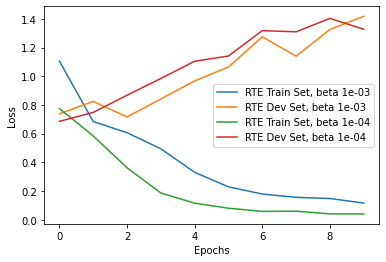

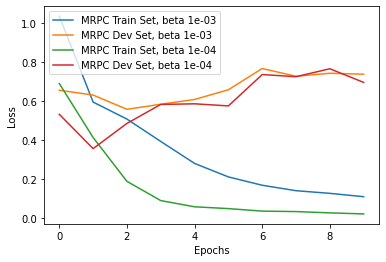

In [ ]:
import matplotlib.pyplot as plt
rte_train_loss = [1.1048656228710623, 0.6840196859602835, 0.6065010638797984, 0.49441171715072557, 0.3303750535728885, 0.22947271102491548, 0.17925063075095998, 0.15636680596599392, 0.14810886781881838, 0.11634161586270612]
mrpc_train_loss = [1.033039130416571, 0.5938807597347334, 0.506886244988909, 0.39245667337786916, 0.2799694681284474, 0.2109561374082285, 0.16830027979962967, 0.1404654908121801, 0.12685256575544676, 0.10973908222627406]
rte_dev_loss  = [0.7373840900567862, 0.8249692297898806, 0.7162189483642578, 0.8412233247206762, 0.9673777130933908, 1.0642799161947691, 1.274667888879776, 1.1392017465371351, 1.3254191394035633, 1.4177790398781116]
mrpc_dev_loss = [0.6544087781355932, 0.6297953587311965, 0.5568436017403235, 0.582781576193296, 0.6071517616510391, 0.6568600970965165, 0.7656649901316717, 0.7258225553310834, 0.7412626227507224, 0.7365222435731155]
rte_train_loss_1 = [0.7750658556526783, 0.5839595137273564, 0.3623182758981106, 0.18668376771258374, 0.11544408676598002, 0.08070473920773058, 0.058435393168645745, 0.06003689840801206, 0.040856739999178576, 0.041136031075581614]
mrpc_train_loss_1 = [0.6888802857959971, 0.4125157302501155, 0.18832684074546777, 0.08987735615422328, 0.0581227570370424, 0.048829952017495445, 0.03593965754935555, 0.03365324404748047, 0.02688894014549898, 0.021642265101785168]
rte_dev_loss_1  = [0.6855802169212928, 0.7480734082368704, 0.8674726807154142, 0.9842896335400068, 1.1043801170129042, 1.140833162344419, 1.3175011506447425, 1.3092539929426634, 1.402744316137754, 1.3269579250078936]
mrpc_dev_loss_1 = [0.5314731712524707, 0.3557314259501604, 0.4846974473733168, 0.5817678479047922, 0.5850505719964321, 0.5742644340946124, 0.7346780655475763, 0.72365936006491, 0.7643713681743696, 0.6945428596093104]
plt.plot(range(len(rte_train_loss)),rte_train_loss,label="RTE Train Set, beta 1e-03")
plt.plot(range(len(rte_dev_loss)),rte_dev_loss,label="RTE Dev Set, beta 1e-03")
plt.plot(range(len(rte_train_loss_1)),rte_train_loss_1,label="RTE Train Set, beta 1e-04")
plt.plot(range(len(rte_dev_loss_1)),rte_dev_loss_1,label="RTE Dev Set, beta 1e-04")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(range(len(mrpc_train_loss)),mrpc_train_loss,label="MRPC Train Set, beta 1e-03")
plt.plot(range(len(mrpc_dev_loss)),mrpc_dev_loss,label="MRPC Dev Set, beta 1e-03")
plt.plot(range(len(mrpc_train_loss_1)),mrpc_train_loss_1,label="MRPC Train Set, beta 1e-04")
plt.plot(range(len(mrpc_dev_loss_1)),mrpc_dev_loss_1,label="MRPC Dev Set, beta 1e-04")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [ ]:
import transformers
from tqdm import tqdm
from sklearn.metrics import accuracy_score,f1_score

n_epochs = 5 #10
device="cuda"
#vibert.train()
vibert.to(device)
vibert.zero_grad()
set_seed(2022)
for epoch in range(n_epochs):
  total_train_loss_rte = 0
  total_train_loss_mrpc = 0
  total_dev_loss_rte = 0
  total_dev_loss_mrpc = 0
  total_train_acc_rte = 0
  total_train_acc_mrpc = 0
  total_dev_acc_rte = 0
  total_dev_acc_mrpc = 0
  vibert.train()
  c1_train=0
  c2_train=0
  for labels,inp1,inp2,st in tqdm(train_dataloader):
    
    optimizer.zero_grad()
    batch = tokenizer(text=inp1,text_pair=inp2,max_length=128,truncation=True,padding=True,add_special_tokens=True,is_split_into_words=False,return_tensors='pt')
    batch.to(device)
  
    out = vibert(batch["input_ids"],token_type_ids=batch["token_type_ids"], 
                             attention_mask=batch["attention_mask"],labels=labels.to(device),dataset_name=st[0])
    loss = out["loss"]["loss"]
    loss.backward()
    optimizer.step()
    scheduler.step()  # Update learning rate schedule
    vibert.zero_grad()
    
    if st[0]=="rte":
      total_train_loss_rte += loss.item()
      total_train_acc_rte += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())  
      c1_train+=1
    if st[0]=="mrpc":
      total_train_loss_mrpc += loss.item()
      total_train_acc_mrpc += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
      c2_train+=1
    torch.nn.utils.clip_grad_norm_(vibert.parameters(), 1.0)
  
  print("Epoch "+str(epoch)+" RTE Train Loss: "+str(total_train_loss_rte/c1_train)+" MRPC Train Loss: "+str(total_train_loss_mrpc/c2_train))
  print(" RTE Train Acc: "+str(total_train_acc_rte/c1_train)+" MRPC Train Acc: "+str(total_train_acc_mrpc/c2_train))
  
  vibert.eval()
  c1_dev=0
  c2_dev=0
  for labels,inp1,inp2,st in tqdm(dev_dataloader):
    
    batch = tokenizer(text=inp1,text_pair=inp2,max_length=128,truncation=True,padding=True,is_split_into_words=False,return_tensors='pt')
    batch.to(device)
    
    out = vibert(batch["input_ids"],token_type_ids=batch["token_type_ids"], 
                             attention_mask=batch["attention_mask"],labels=labels.to(device),dataset_name=st[0])
    loss = out["loss"]["loss"]
    if st[0]=="rte":
      total_dev_loss_rte += loss.item()
      total_dev_acc_rte += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
      c1_dev+=1
    if st[0]=="mrpc":
      total_dev_loss_mrpc += loss.item()
      total_dev_acc_mrpc += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
      c2_dev+=1
     
  print("Epoch "+str(epoch)+" RTE Val Loss: "+str(total_dev_loss_rte/c1_dev)+" MRPC Val Loss: "+str(total_dev_loss_mrpc/c2_dev))
  print(" RTE Val Acc: "+str(total_dev_acc_rte/c1_dev)+" MRPC Val Acc: "+str(total_dev_acc_mrpc/c2_dev))
  
  torch.save(vibert.state_dict(), "vibert_70_new")

In [ ]:
from tqdm import tqdm
device="cuda"
#vibert.train()
vibert.to(device)
set_seed(2022)
vibert.eval()
total_test_loss_rte = 0
total_test_loss_mrpc = 0
total_test_acc_rte = 0
total_test_acc_mrpc = 0
total_test_f1_rte = 0
total_test_f1_mrpc = 0
c1=1
c2=0
epoch=1
for labels,inp1,inp2,st in tqdm(mrpc_test_dataloader):
  
  batch = tokenizer(text=inp1,text_pair=inp2,max_length=128,truncation=True,padding=True,is_split_into_words=False,return_tensors='pt')
  batch.to(device)
  out = vibert(batch["input_ids"],token_type_ids=batch["token_type_ids"], 
                             attention_mask=batch["attention_mask"],labels=labels.to(device),dataset_name=st[0],logits=None,label=None,sampled_logits=None,kl_loss=None)
  loss = out["loss"]["loss"]
  if st[0]=="rte":
    total_test_loss_rte += loss.item()
    total_test_acc_rte += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
    total_test_f1_rte += f1_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
    c1+=1
  if st[0]=="mrpc":
    total_test_loss_mrpc += loss.item()
    total_test_acc_mrpc += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
    total_test_f1_mrpc += f1_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
    c2+=1
    
print("Epoch "+str(epoch)+" RTE Test Loss: "+str(total_test_loss_rte/c1)+" MRPC Test Loss: "+str(total_test_loss_mrpc/c2))
print(" RTE Test Acc: "+str(total_test_acc_rte/c1)+" MRPC Test Acc: "+str(total_test_acc_mrpc/c2))
print(" RTE Test F1: "+str(total_test_f1_rte/c1)+" MRPC Test F1: "+str(total_test_f1_mrpc/c2))

100%|██████████| 54/54 [00:11<00:00,  4.71it/s]

Epoch 1 RTE Test Loss: 0.0 MRPC Test Loss: 0.7089270411266221
 RTE Test Acc: 0.0 MRPC Test Acc: 0.8156130268199234
 RTE Test F1: 0.0 MRPC Test F1: 0.8665413918334518


In [ ]:
from tqdm import tqdm
device="cuda"
#vibert.train()
vibert.to(device)
set_seed(2022)
vibert.eval()
total_test_loss_rte = 0
total_test_loss_mrpc = 0
total_test_acc_rte = 0
total_test_acc_mrpc = 0
total_test_f1_rte = 0
total_test_f1_mrpc = 0
c1=1
c2=0
epoch=1
for labels,inp1,inp2,st in tqdm(dev_dataloader):
  
  batch = tokenizer(text=inp1,text_pair=inp2,max_length=128,truncation=True,padding=True,is_split_into_words=False,return_tensors='pt')
  batch.to(device)
  out = vibert(batch["input_ids"],token_type_ids=batch["token_type_ids"], 
                             attention_mask=batch["attention_mask"],labels=labels.to(device),dataset_name=st[0],logits=None,label=None,sampled_logits=None,kl_loss=None)
  loss = out["loss"]["loss"]
  if st[0]=="rte":
    total_test_loss_rte += loss.item()
    total_test_acc_rte += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
    total_test_f1_rte += f1_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
    c1+=1
  if st[0]=="mrpc":
    total_test_loss_mrpc += loss.item()
    total_test_acc_mrpc += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
    total_test_f1_mrpc += f1_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
    c2+=1
    
print("Epoch "+str(epoch)+" RTE Test Loss: "+str(total_test_loss_rte/c1)+" MRPC Test Loss: "+str(total_test_loss_mrpc/c2))
print(" RTE Test Acc: "+str(total_test_acc_rte/c1)+" MRPC Test Acc: "+str(total_test_acc_mrpc/c2))
print(" RTE Test F1: "+str(total_test_f1_rte/c1)+" MRPC Test F1: "+str(total_test_f1_mrpc/c2))

100%|██████████| 52/52 [00:12<00:00,  4.32it/s]

Epoch 1 RTE Test Loss: 1.2112525546992268 MRPC Test Loss: 0.615862872881385
 RTE Test Acc: 0.6319444444444444 MRPC Test Acc: 0.8353365384615384
 RTE Test F1: 0.543354377831561 MRPC Test F1: 0.8833373624766494


In [ ]:
from tqdm import tqdm
device="cuda"
#vibert.train()
vibert.to(device)
set_seed(2022)
vibert.eval()
total_test_loss_rte = 0
total_test_loss_mrpc = 0
total_test_acc_rte = 0
total_test_acc_mrpc = 0
total_test_f1_rte = 0
total_test_f1_mrpc = 0
c1=1
c2=0
epoch=1
for labels,inp1,inp2,st in tqdm(dev_dataloader):
  
  batch = tokenizer(text=inp1,text_pair=inp2,max_length=128,truncation=True,padding=True,is_split_into_words=False,return_tensors='pt')
  batch.to(device)
  out = vibert(batch["input_ids"],token_type_ids=batch["token_type_ids"], 
                             attention_mask=batch["attention_mask"],labels=labels.to(device),dataset_name=st[0],logits=None,label=None,sampled_logits=None,kl_loss=None)
  loss = out["loss"]["loss"]
  if st[0]=="rte":
    total_test_loss_rte += loss.item()
    total_test_acc_rte += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
    total_test_f1_rte += f1_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
    c1+=1
  if st[0]=="mrpc":
    total_test_loss_mrpc += loss.item()
    total_test_acc_mrpc += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
    total_test_f1_mrpc += f1_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
    c2+=1
    
print("Epoch "+str(epoch)+" RTE Test Loss: "+str(total_test_loss_rte/c1)+" MRPC Test Loss: "+str(total_test_loss_mrpc/c2))
print(" RTE Test Acc: "+str(total_test_acc_rte/c1)+" MRPC Test Acc: "+str(total_test_acc_mrpc/c2))
print(" RTE Test F1: "+str(total_test_f1_rte/c1)+" MRPC Test F1: "+str(total_test_f1_mrpc/c2))

100%|██████████| 52/52 [00:10<00:00,  4.74it/s]

Epoch 1 RTE Test Loss: 1.280003062000981 MRPC Test Loss: 0.6871244019040694
 RTE Test Acc: 0.6527777777777778 MRPC Test Acc: 0.828125
 RTE Test F1: 0.6436523232285588 MRPC Test F1: 0.8765453009343809


In [ ]:
from tqdm import tqdm
device="cuda"
#vibert.train()
vibert.to(device)
set_seed(2022)
vibert.eval()
total_test_loss_rte = 0
total_test_loss_mrpc = 0
total_test_acc_rte = 0
total_test_acc_mrpc = 0
total_test_f1_rte = 0
total_test_f1_mrpc = 0
c1=1
c2=0
epoch=1
for labels,inp1,inp2,st in tqdm(dev_dataloader):
  
  batch = tokenizer(text=inp1,text_pair=inp2,max_length=128,truncation=True,padding=True,is_split_into_words=False,return_tensors='pt')
  batch.to(device)
  out = vibert(batch["input_ids"],token_type_ids=batch["token_type_ids"], 
                             attention_mask=batch["attention_mask"],labels=labels.to(device),dataset_name=st[0],logits=None,label=None,sampled_logits=None,kl_loss=None)
  loss = out["loss"]["loss"]
  if st[0]=="rte":
    total_test_loss_rte += loss.item()
    total_test_acc_rte += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
    total_test_f1_rte += f1_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
    c1+=1
  if st[0]=="mrpc":
    total_test_loss_mrpc += loss.item()
    total_test_acc_mrpc += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
    total_test_f1_mrpc += f1_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
    c2+=1
    
print("Epoch "+str(epoch)+" RTE Test Loss: "+str(total_test_loss_rte/c1)+" MRPC Test Loss: "+str(total_test_loss_mrpc/c2))
print(" RTE Test Acc: "+str(total_test_acc_rte/c1)+" MRPC Test Acc: "+str(total_test_acc_mrpc/c2))
print(" RTE Test F1: "+str(total_test_f1_rte/c1)+" MRPC Test F1: "+str(total_test_f1_mrpc/c2))

100%|██████████| 52/52 [00:12<00:00,  4.04it/s]

Epoch 1 RTE Test Loss: 1.4761454926596747 MRPC Test Loss: 0.7835625788340201
 RTE Test Acc: 0.5891203703703703 MRPC Test Acc: 0.7776442307692307
 RTE Test F1: 0.5842723926370899 MRPC Test F1: 0.836523252732936


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, MSELoss
from transformers import RobertaPreTrainedModel, RobertaModel,RobertaConfig
class RobertaForSequenceClassification(RobertaPreTrainedModel):
    def __init__(self,config):
        super().__init__(config)
        self.num_labels = 2
        #config = BertConfig()
        self.roberta = RobertaModel(config)
        self.dropout = nn.Dropout(0.2)
        self.deterministic = False
        self.ib_dim = 384
        self.ib = True
        #self.deterministic = True
        self.activation = 'relu'
        self.activations = {'tanh': nn.Tanh(), 'relu': nn.ReLU(), 'sigmoid': nn.Sigmoid()}
        if self.ib or self.deterministic:
            self.kl_annealing = "linear"
            self.hidden_dim = (768 + self.ib_dim) // 2
            intermediate_dim = (self.hidden_dim+768)//2
            self.mlp_rte = nn.Sequential(
                nn.Linear(768, intermediate_dim), #768
                self.activations[self.activation],
                nn.Linear(intermediate_dim, self.hidden_dim),
                self.activations[self.activation])
            self.mlp_mrpc = nn.Sequential(
                nn.Linear(768, intermediate_dim), #768
                self.activations[self.activation],
                nn.Linear(intermediate_dim, self.hidden_dim),
                self.activations[self.activation])
            self.beta = 1e-04
            self.sample_size = 5 
            self.emb2mu_rte = nn.Linear(self.hidden_dim, self.ib_dim)
            self.emb2std_rte = nn.Linear(self.hidden_dim, self.ib_dim)
            self.mu_p_rte = nn.Parameter(torch.randn(self.ib_dim))
            self.std_p_rte = nn.Parameter(torch.randn(self.ib_dim))
            self.emb2mu_mrpc = nn.Linear(self.hidden_dim, self.ib_dim)
            self.emb2std_mrpc = nn.Linear(self.hidden_dim, self.ib_dim)
            self.mu_p_mrpc = nn.Parameter(torch.randn(self.ib_dim))
            self.std_p_mrpc = nn.Parameter(torch.randn(self.ib_dim))
            self.classifier_rte = nn.Linear(self.ib_dim, self.num_labels)
            self.classifier_mrpc = nn.Linear(self.ib_dim, self.num_labels) 
        else:
            self.classifier = nn.Linear(768, self.num_labels)

        self.init_weights()

    def estimate(self, emb, emb2mu, emb2std):
        """Estimates mu and std from the given input embeddings."""
        mean = emb2mu(emb)
        std = torch.nn.functional.softplus(emb2std(emb))
        return mean, std

    def kl_div(self, mu_q, std_q, mu_p, std_p):
        """Computes the KL divergence between the two given variational distribution.\
           This computes KL(q||p), which is not symmetric. It quantifies how far is\
           The estimated distribution q from the true distribution of p."""
        k = mu_q.size(1)
        mu_diff = mu_p - mu_q
        mu_diff_sq = torch.mul(mu_diff, mu_diff)
        logdet_std_q = torch.sum(2 * torch.log(torch.clamp(std_q, min=1e-8)), dim=1)
        logdet_std_p = torch.sum(2 * torch.log(torch.clamp(std_p, min=1e-8)), dim=1)
        fs = torch.sum(torch.div(std_q ** 2, std_p ** 2), dim=1) + torch.sum(torch.div(mu_diff_sq, std_p ** 2), dim=1)
        kl_divergence = (fs - k + logdet_std_p - logdet_std_q)*0.5
        return kl_divergence.mean()

    def reparameterize(self, mu, std):
        batch_size = mu.shape[0]
        z = torch.randn(self.sample_size, batch_size, mu.shape[1]).cuda()
        return mu + std * z

    def get_logits(self, z, mu, sampling_type,dataset_name):
        if sampling_type == "iid":
            if dataset_name == "rte":
              logits = self.classifier_rte(z)
            else:
              logits = self.classifier_mrpc(z)
            mean_logits = logits.mean(dim=0)
            logits = logits.permute(1, 2, 0)
        else:
            if dataset_name == 0:
              mean_logits = self.classifier_rte(mu)
            else:
              mean_logits = self.classifier_mrpc(mu)
            #mean_logits = self.classifier(mu)
            logits = mean_logits
        return logits, mean_logits


    def sampled_loss(self, logits, mean_logits, labels, sampling_type):
        if sampling_type == "iid":
            # During the training, computes the loss with the sampled embeddings.
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.sample_size), labels[:, None].float().expand(-1, self.sample_size))
                loss = torch.mean(loss, dim=-1)
                loss = torch.mean(loss, dim=0)
            else:
                loss_fct = CrossEntropyLoss(reduce=False)
                loss = loss_fct(logits, labels[:, None].expand(-1, self.sample_size))
                loss = torch.mean(loss, dim=-1)
                loss = torch.mean(loss, dim=0)
        else:
            # During test time, uses the average value for prediction.
            if self.num_labels == 1:
                loss_fct = MSELoss()
                loss = loss_fct(mean_logits.view(-1), labels.float().view(-1))
            else:
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(mean_logits, labels)
        return loss

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        sampling_type="iid",
        epoch=1,
        **kwargs
        #dataset_name="rte",
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`, defaults to :obj:`None`):
            Labels for computing the sequence classification/regression loss.
            Indices should be in :obj:`[0, ..., config.num_labels - 1]`.
            If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
            If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).
    Returns:
        :obj:`tuple(torch.FloatTensor)` comprising various elements depending on the configuration (:class:`~transformers.BertConfig`) and inputs:
        loss (:obj:`torch.FloatTensor` of shape :obj:`(1,)`, `optional`, returned when :obj:`label` is provided):
            Classification (or regression if config.num_labels==1) loss.
        logits (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, config.num_labels)`):
            Classification (or regression if config.num_labels==1) scores (before SoftMax).
        hidden_states (:obj:`tuple(torch.FloatTensor)`, `optional`, returned when ``config.output_hidden_states=True``):
            Tuple of :obj:`torch.FloatTensor` (one for the output of the embeddings + one for the output of each layer)
            of shape :obj:`(batch_size, sequence_length, hidden_size)`.
            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        attentions (:obj:`tuple(torch.FloatTensor)`, `optional`, returned when ``config.output_attentions=True``):
            Tuple of :obj:`torch.FloatTensor` (one for each layer) of shape
            :obj:`(batch_size, num_heads, sequence_length, sequence_length)`.
            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention
            heads.
    Examples::
        from transformers import BertTokenizer, BertForSequenceClassification
        import torch
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
        input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
        labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
        outputs = model(input_ids, labels=labels)
        loss, logits = outputs[:2]
        """
        #dataset_name="rte"
        #print(position_ids.item())
        position_id = None
        final_outputs = {}
        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_id,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        loss = {}

        if self.deterministic:
            pooled_output = self.mlp(pooled_output)
            mu, std = self.estimate(pooled_output, self.emb2mu, self.emb2std)
            final_outputs["z"] = mu
            sampled_logits, logits = self.get_logits(mu, mu, sampling_type='argmax',dataset_name=kwargs["dataset_name"]) # always deterministic
            if labels is not None:
                loss["loss"] = self.sampled_loss(sampled_logits, logits, labels.view(-1), sampling_type='argmax')

        elif self.ib:
            if kwargs["dataset_name"]=="rte":
              pooled_output = self.mlp_rte(pooled_output)
              batch_size = pooled_output.shape[0]
              mu, std = self.estimate(pooled_output, self.emb2mu_rte, self.emb2std_rte)
              mu_p = self.mu_p_rte.view(1, -1).expand(batch_size, -1)
              std_p = torch.nn.functional.softplus(self.std_p_rte.view(1, -1).expand(batch_size, -1))
            else:
              pooled_output = self.mlp_mrpc(pooled_output)
              batch_size = pooled_output.shape[0]
              mu, std = self.estimate(pooled_output, self.emb2mu_mrpc, self.emb2std_mrpc)
              mu_p = self.mu_p_mrpc.view(1, -1).expand(batch_size, -1)
              std_p = torch.nn.functional.softplus(self.std_p_mrpc.view(1, -1).expand(batch_size, -1))
            kl_loss = self.kl_div(mu, std, mu_p, std_p)
            z = self.reparameterize(mu, std)
            final_outputs["z"] = mu

            if self.kl_annealing == "linear":
                beta = min(1.0, epoch*self.beta)
                 
            sampled_logits, logits = self.get_logits(z, mu, sampling_type,dataset_name=kwargs["dataset_name"])
            #print(labels)
            if labels is not None:
                if kwargs["label"] is not None:
                  ce_loss_rte = self.sampled_loss(kwargs["sampled_logits"], kwargs["logits"], kwargs["label"].view(-1), sampling_type)
                  total_loss_rte = ce_loss_rte + (beta if self.kl_annealing == "linear" else self.beta) * kwargs["kl_loss"]
                  ce_loss_mrpc = self.sampled_loss(sampled_logits, logits, labels.view(-1), sampling_type)
                  total_loss_mrpc = ce_loss_mrpc + (beta if self.kl_annealing == "linear" else self.beta) * kl_loss
                  total_loss = total_loss_rte + total_loss_mrpc
                else:
                  ce_loss = self.sampled_loss(sampled_logits, logits, labels.view(-1), sampling_type)
                  total_loss = ce_loss + (beta if self.kl_annealing == "linear" else self.beta) * kl_loss
                loss["loss"] = total_loss
        else:
            final_outputs["z"] = pooled_output
            logits = self.classifier(pooled_output)
            if labels is not None:
                if self.num_labels == 1:
                    #  We are doing regression
                    loss_fct = MSELoss()
                    loss["loss"] = loss_fct(logits.view(-1), labels.float().view(-1))
                else:
                    loss_fct = CrossEntropyLoss()
                    loss["loss"] = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
                    
        final_outputs.update({"logits": logits, "loss": loss, "hidden_attention": outputs[2:],"sampled_logits":sampled_logits,"kl_loss":kl_loss})
        return final_outputs

In [ ]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)
config = RobertaConfig.from_pretrained(
        "roberta-base",
        num_labels=2)
viroberta = RobertaForSequenceClassification.from_pretrained(
        "roberta-base",
        config=config
)

In [ ]:
for name, param in viroberta.named_parameters():
    if param.requires_grad:
        print(name)

mu_p_rte
std_p_rte
mu_p_mrpc
std_p_mrpc
roberta.embeddings.word_embeddings.weight
roberta.embeddings.position_embeddings.weight
roberta.embeddings.token_type_embeddings.weight
roberta.embeddings.LayerNorm.weight
roberta.embeddings.LayerNorm.bias
roberta.encoder.layer.0.attention.self.query.weight
roberta.encoder.layer.0.attention.self.query.bias
roberta.encoder.layer.0.attention.self.key.weight
roberta.encoder.layer.0.attention.self.key.bias
roberta.encoder.layer.0.attention.self.value.weight
roberta.encoder.layer.0.attention.self.value.bias
roberta.encoder.layer.0.attention.output.dense.weight
roberta.encoder.layer.0.attention.output.dense.bias
roberta.encoder.layer.0.attention.output.LayerNorm.weight
roberta.encoder.layer.0.attention.output.LayerNorm.bias
roberta.encoder.layer.0.intermediate.dense.weight
roberta.encoder.layer.0.intermediate.dense.bias
roberta.encoder.layer.0.output.dense.weight
roberta.encoder.layer.0.output.dense.bias
roberta.encoder.layer.0.output.LayerNorm.weight


In [ ]:
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
        {
            "params": [p for n, p in viroberta.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
        {"params": [p for n, p in viroberta.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
]
optimizer = AdamW(optimizer_grouped_parameters, lr=5e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,
                                                num_training_steps=len(train_dataloader)*10)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning) 

In [ ]:
import transformers
transformers.logging.set_verbosity_error()

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    #if args.n_gpu > 0:
    #    torch.cuda.manual_seed_all(args.seed)
    torch.cuda.manual_seed(seed)

In [ ]:
import transformers
from tqdm import tqdm
from sklearn.metrics import accuracy_score,f1_score

n_epochs = 5 #10
device="cuda"
#vibert.train()
viroberta.to(device)
viroberta.zero_grad()
set_seed(2022)
train_loss_rte=[]
train_loss_mrpc=[]
dev_loss_rte=[]
dev_loss_mrpc=[]
train_acc_rte=[]
train_acc_mrpc=[]
dev_acc_rte=[]
dev_acc_mrpc=[]
total_loss=[]

for epoch in range(n_epochs):
  total_train_loss_rte = 0
  total_train_loss_mrpc = 0
  total_dev_loss_rte = 0
  total_dev_loss_mrpc = 0
  total_train_acc_rte = 0
  total_train_acc_mrpc = 0
  total_dev_acc_rte = 0
  total_dev_acc_mrpc = 0
  total_train_loss=0
  vibert.train()
  c1_train=0
  c2_train=0
  c=0
  logs=None
  labs = None
  sampled_labs = None
  kl_loss= None
  for labels,inp1,inp2,st in tqdm(train_dataloader):
    
    optimizer.zero_grad()
    batch = tokenizer(text=inp1,text_pair=inp2,max_length=128,truncation=True,padding=True,add_special_tokens=True,is_split_into_words=False,return_tensors='pt')
    batch.to(device)

    #with torch.set_grad_enabled(True):
    out = viroberta(batch["input_ids"],token_type_ids=None, 
                            attention_mask=batch["attention_mask"],labels=labels.to(device),dataset_name=st[0],logits=logs,label=labs,sampled_logits=sampled_labs,kl_loss=kl_loss)
    
    #loss = (loss*0.5)/2 
    logs= out["logits"].to(device)
    labs=labels.to(device)
    sampled_labs = out["sampled_logits"].to(device)
    kl_loss = out["kl_loss"]
    f=0
    if st[0]=="rte":
      c1_train+=1
    if st[0]=="mrpc":
      c2_train+=1
    
    if c1_train == c2_train:
      loss = out["loss"]["loss"]  
      total_train_loss+=loss.item()
      c+=1
      loss.backward()
      optimizer.step()
      scheduler.step()  # Update learning rate schedule
      viroberta.zero_grad()
      logs=None
      labs = None
      sampled_labs=None
      kl_loss = None
      
      f=1
      torch.nn.utils.clip_grad_norm_(vibert.parameters(), 1.0)
    if st[0]=="rte":
        out = viroberta(batch["input_ids"],token_type_ids=None, 
                            attention_mask=batch["attention_mask"],labels=labels.to(device),dataset_name=st[0],logits=None,label=None,sampled_logits=None,kl_loss=None)
        loss = out["loss"]["loss"]
        total_train_loss_rte += loss.item()
        total_train_acc_rte += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())  
    if st[0]=="mrpc":
      #total_train_loss_mrpc += loss.item()
      out = viroberta(batch["input_ids"],token_type_ids=None, 
                            attention_mask=batch["attention_mask"],labels=labels.to(device),dataset_name=st[0],logits=None,label=None,sampled_logits=None,kl_loss=None)
      loss = out["loss"]["loss"]
      total_train_loss_mrpc += loss.item()
      total_train_acc_mrpc += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
    #if f==0 and c1_train+c2_train>=len(train_dataloader):
    #  optimizer.step()
    #  scheduler.step()  # Update learning rate schedule
    #  vibert.zero_grad()
  print("Epoch "+str(epoch)+" RTE Train Loss: "+str(total_train_loss/len(train_dataloader)))
  print("Epoch "+str(epoch)+" RTE Train Loss: "+str(total_train_loss_rte/c1_train)+" MRPC Train Loss: "+str(total_train_loss_mrpc/c2_train))
  print(" RTE Train Acc: "+str(total_train_acc_rte/c1_train)+" MRPC Train Acc: "+str(total_train_acc_mrpc/c2_train))
  total_loss.append(total_train_loss/c)
  train_loss_rte.append(total_train_loss_rte/c1_train)
  train_loss_mrpc.append(total_train_loss_mrpc/c2_train)
  train_acc_rte.append(total_train_acc_rte/c1_train)
  train_acc_mrpc.append(total_train_acc_mrpc/c2_train)
  

  
  vibert.eval()
  c1_dev=0
  c2_dev=0
  for labels,inp1,inp2,st in tqdm(dev_dataloader):
    
    batch = tokenizer(text=inp1,text_pair=inp2,max_length=128,truncation=True,padding=True,is_split_into_words=False,return_tensors='pt')
    batch.to(device)
    
    out = viroberta(batch["input_ids"],token_type_ids=None, 
                             attention_mask=batch["attention_mask"],labels=labels.to(device),dataset_name=st[0],logits=None,label=None,sampled_logits=None,kl_loss=None)
    loss = out["loss"]["loss"]
    if st[0]=="rte":
      total_dev_loss_rte += loss.item()
      total_dev_acc_rte += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
      c1_dev+=1
    if st[0]=="mrpc":
      total_dev_loss_mrpc += loss.item()
      total_dev_acc_mrpc += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
      c2_dev+=1
     
  print("Epoch "+str(epoch)+" RTE Val Loss: "+str(total_dev_loss_rte/c1_dev)+" MRPC Val Loss: "+str(total_dev_loss_mrpc/c2_dev))
  print(" RTE Val Acc: "+str(total_dev_acc_rte/c1_dev)+" MRPC Val Acc: "+str(total_dev_acc_mrpc/c2_dev))
  
  dev_loss_rte.append(total_dev_loss_rte/c1_dev)
  dev_loss_mrpc.append(total_dev_loss_mrpc/c2_dev)
  dev_acc_rte.append(total_dev_acc_rte/c1_dev)
  dev_acc_mrpc.append(total_dev_acc_mrpc/c2_dev)
  torch.save(vibert.state_dict(), "vibert_70")


print("Total_train_loss : ",total_loss)
print("RTE Train Loss: ",train_loss_rte)
print("MRPC Train Loss: ",train_loss_mrpc)
print("RTE Dev Loss: ",dev_loss_rte)
print("MRPC Dev Loss: ",dev_loss_mrpc)
print("RTE Train Acc: ",train_acc_rte)
print("MRPC Train Acc: ",train_acc_mrpc)
print("RTE Dev Acc: ",dev_acc_rte)
print("MRPC Dev Acc: ",dev_acc_mrpc)

100%|██████████| 204/204 [02:19<00:00,  1.46it/s]


Epoch 0 RTE Train Loss: 0.7387236894345751
Epoch 0 RTE Train Loss: 0.8145382036181057 MRPC Train Loss: 0.6192540765977373
 RTE Train Acc: 0.4993872549019608 MRPC Train Acc: 0.7300857843137255


100%|██████████| 52/52 [00:09<00:00,  5.36it/s]


Epoch 0 RTE Val Loss: 0.7256500377104833 MRPC Val Loss: 0.4192550308429278
 RTE Val Acc: 0.49399038461538464 MRPC Val Acc: 0.8401442307692307


100%|██████████| 204/204 [02:25<00:00,  1.40it/s]


Epoch 1 RTE Train Loss: 0.5642307435764986
Epoch 1 RTE Train Loss: 0.7218116030973547 MRPC Train Loss: 0.3347247585508169
 RTE Train Acc: 0.5033700980392157 MRPC Train Acc: 0.8762254901960784


100%|██████████| 52/52 [00:09<00:00,  5.32it/s]


Epoch 1 RTE Val Loss: 0.7109171610612136 MRPC Val Loss: 0.3707012918133002
 RTE Val Acc: 0.5252403846153846 MRPC Val Acc: 0.8449519230769231


100%|██████████| 204/204 [02:26<00:00,  1.39it/s]


Epoch 2 RTE Train Loss: 0.47150760158604266
Epoch 2 RTE Train Loss: 0.7026020492993149 MRPC Train Loss: 0.16982318950342198
 RTE Train Acc: 0.5471813725490197 MRPC Train Acc: 0.9549632352941176


100%|██████████| 52/52 [00:10<00:00,  4.79it/s]


Epoch 2 RTE Val Loss: 0.6883068336890295 MRPC Val Loss: 0.33044513028401595
 RTE Val Acc: 0.5769230769230769 MRPC Val Acc: 0.8617788461538461


100%|██████████| 204/204 [02:26<00:00,  1.39it/s]


Epoch 3 RTE Train Loss: 0.3496816056031807
Epoch 3 RTE Train Loss: 0.5716955243956809 MRPC Train Loss: 0.0780253768442016
 RTE Train Acc: 0.7282475490196079 MRPC Train Acc: 0.9859068627450981


100%|██████████| 52/52 [00:09<00:00,  5.30it/s]


Epoch 3 RTE Val Loss: 0.7690158967788403 MRPC Val Loss: 0.3557808525287188
 RTE Val Acc: 0.6274038461538461 MRPC Val Acc: 0.8617788461538461


100%|██████████| 204/204 [02:26<00:00,  1.40it/s]


Epoch 4 RTE Train Loss: 0.19933091421775959
Epoch 4 RTE Train Loss: 0.3175708353884664 MRPC Train Loss: 0.04954649093469568
 RTE Train Acc: 0.8857230392156863 MRPC Train Acc: 0.9938725490196079


100%|██████████| 52/52 [00:09<00:00,  5.29it/s]


Epoch 4 RTE Val Loss: 0.8695118610675519 MRPC Val Loss: 0.43847251855410063
 RTE Val Acc: 0.6923076923076923 MRPC Val Acc: 0.8701923076923077
Total_train_loss :  [1.4774473788691502, 1.1284614871529972, 0.9430152031720853, 0.6993632112063614, 0.39866182843551917]
RTE Train Loss:  [0.8145382036181057, 0.7218116030973547, 0.7026020492993149, 0.5716955243956809, 0.3175708353884664]
MRPC Train Loss:  [0.6192540765977373, 0.3347247585508169, 0.16982318950342198, 0.0780253768442016, 0.04954649093469568]
RTE Dev Loss:  [0.7256500377104833, 0.7109171610612136, 0.6883068336890295, 0.7690158967788403, 0.8695118610675519]
MRPC Dev Loss:  [0.4192550308429278, 0.3707012918133002, 0.33044513028401595, 0.3557808525287188, 0.43847251855410063]
RTE Train Acc:  [0.4993872549019608, 0.5033700980392157, 0.5471813725490197, 0.7282475490196079, 0.8857230392156863]
MRPC Train Acc:  [0.7300857843137255, 0.8762254901960784, 0.9549632352941176, 0.9859068627450981, 0.9938725490196079]
RTE Dev Acc:  [0.4939903846

In [ ]:
from tqdm import tqdm
device="cuda"
#vibert.train()
viroberta.to(device)
set_seed(2022)
vibert.eval()
total_test_loss_rte = 0
total_test_loss_mrpc = 0
total_test_acc_rte = 0
total_test_acc_mrpc = 0
total_test_f1_rte = 0
total_test_f1_mrpc = 0
c1=1
c2=0
epoch=1
for labels,inp1,inp2,st in tqdm(mrpc_test_dataloader):
  
  batch = tokenizer(text=inp1,text_pair=inp2,max_length=128,truncation=True,padding=True,is_split_into_words=False,return_tensors='pt')
  batch.to(device)
  out = viroberta(batch["input_ids"],token_type_ids=None, 
                             attention_mask=batch["attention_mask"],labels=labels.to(device),dataset_name=st[0],logits=None,label=None,sampled_logits=None,kl_loss=None)
  loss = out["loss"]["loss"]
  if st[0]=="rte":
    total_test_loss_rte += loss.item()
    total_test_acc_rte += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
    total_test_f1_rte += f1_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
    c1+=1
  if st[0]=="mrpc":
    total_test_loss_mrpc += loss.item()
    total_test_acc_mrpc += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
    total_test_f1_mrpc += f1_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
    c2+=1
    
print("Epoch "+str(epoch)+" RTE Test Loss: "+str(total_test_loss_rte/c1)+" MRPC Test Loss: "+str(total_test_loss_mrpc/c2))
print(" RTE Test Acc: "+str(total_test_acc_rte/c1)+" MRPC Test Acc: "+str(total_test_acc_mrpc/c2))
print(" RTE Test F1: "+str(total_test_f1_rte/c1)+" MRPC Test F1: "+str(total_test_f1_mrpc/c2))

100%|██████████| 54/54 [00:10<00:00,  5.34it/s]


Epoch 1 RTE Test Loss: 0.0 MRPC Test Loss: 0.4533645397535077
 RTE Test Acc: 0.0 MRPC Test Acc: 0.8557830459770115
 RTE Test F1: 0.0 MRPC Test F1: 0.8854379131077169


In [ ]:
Shared Encoder beta 1e-04

Total_train_loss :  [1.4752381292043948, 1.0763221412312751, 0.7535858379275191, 0.4824579087834732, 0.26287615898193095]
RTE Train Loss:  [0.7970023856443518, 0.6611801941020816, 0.5197818195995163, 0.353616383291927, 0.19068483595608496]
MRPC Train Loss:  [0.6353617950397379, 0.32936984592793034, 0.1635296375070717, 0.08220969421752528, 0.050292712070193944]
RTE Dev Loss:  [0.7252618257816021, 0.6153905345843389, 0.6958389351001153, 0.7472880757772006, 0.9052459689287039]
MRPC Dev Loss:  [0.5984869473255597, 0.3884557227675731, 0.35589291098026127, 0.4119063802063465, 0.5404707909776614]
RTE Train Acc:  [0.5217524509803921, 0.6314338235294118, 0.7662377450980392, 0.8700980392156863, 0.9463848039215687]
MRPC Train Acc:  [0.6936274509803921, 0.8939950980392157, 0.9613970588235294, 0.9871323529411765, 0.9941789215686274]
RTE Dev Acc:  [0.5396634615384616, 0.7199519230769231, 0.6814903846153846, 0.671875, 0.7271634615384616]
MRPC Dev Acc:  [0.6826923076923077, 0.8461538461538461, 0.8497596153846154, 0.859375, 0.8533653846153846]

Epoch 1 RTE Test Loss: 0.0 MRPC Test Loss: 0.5804826705544083
 RTE Test Acc: 0.0 MRPC Test Acc: 0.8517321200510856
 RTE Test F1: 0.0 MRPC Test F1: 0.8872017898455994

Epoch 1 RTE Test Loss: 0.9051229586968055 MRPC Test Loss: 0.543636390222953
 RTE Test Acc: 0.7259615384615384 MRPC Test Acc: 0.8497596153846154
 RTE Test F1: 0.6913012994273888 MRPC Test F1: 0.8883961952858421


Task Specific Encoder beta 1e-04

Total_train_loss :  [1.4774473788691502, 1.1284614871529972, 0.9430152031720853, 0.6993632112063614, 0.39866182843551917]
RTE Train Loss:  [0.8145382036181057, 0.7218116030973547, 0.7026020492993149, 0.5716955243956809, 0.3175708353884664]
MRPC Train Loss:  [0.6192540765977373, 0.3347247585508169, 0.16982318950342198, 0.0780253768442016, 0.04954649093469568]
RTE Dev Loss:  [0.7256500377104833, 0.7109171610612136, 0.6883068336890295, 0.7690158967788403, 0.8695118610675519]
MRPC Dev Loss:  [0.4192550308429278, 0.3707012918133002, 0.33044513028401595, 0.3557808525287188, 0.43847251855410063]
RTE Train Acc:  [0.4993872549019608, 0.5033700980392157, 0.5471813725490197, 0.7282475490196079, 0.8857230392156863]
MRPC Train Acc:  [0.7300857843137255, 0.8762254901960784, 0.9549632352941176, 0.9859068627450981, 0.9938725490196079]
RTE Dev Acc:  [0.49399038461538464, 0.5252403846153846, 0.5769230769230769, 0.6274038461538461, 0.6923076923076923]
MRPC Dev Acc:  [0.8401442307692307, 0.8449519230769231, 0.8617788461538461, 0.8617788461538461, 0.8701923076923077]

Epoch 1 RTE Test Loss: 0.0 MRPC Test Loss: 0.4533645397535077
 RTE Test Acc: 0.0 MRPC Test Acc: 0.8557830459770115
 RTE Test F1: 0.0 MRPC Test F1: 0.8854379131077169

##Froze the BERT Model(Only using the last layer)

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
config = BertConfig.from_pretrained(
        "bert-base-uncased",
        num_labels=2)
vibert_froze = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        config=config
)

In [ ]:
for name,param in vibert_froze.bert.named_parameters():
    #print(name,"encoder.layer.11" not in name)
    if "encoder.layer.11" not in name:
      param.requires_grad = False
    else:
      break

In [ ]:
for name, param in vibert_froze.named_parameters():
    if param.requires_grad:
        print(name)

mu_p
std_p
bert.encoder.layer.11.attention.self.query.weight
bert.encoder.layer.11.attention.self.query.bias
bert.encoder.layer.11.attention.self.key.weight
bert.encoder.layer.11.attention.self.key.bias
bert.encoder.layer.11.attention.self.value.weight
bert.encoder.layer.11.attention.self.value.bias
bert.encoder.layer.11.attention.output.dense.weight
bert.encoder.layer.11.attention.output.dense.bias
bert.encoder.layer.11.attention.output.LayerNorm.weight
bert.encoder.layer.11.attention.output.LayerNorm.bias
bert.encoder.layer.11.intermediate.dense.weight
bert.encoder.layer.11.intermediate.dense.bias
bert.encoder.layer.11.output.dense.weight
bert.encoder.layer.11.output.dense.bias
bert.encoder.layer.11.output.LayerNorm.weight
bert.encoder.layer.11.output.LayerNorm.bias
bert.pooler.dense.weight
bert.pooler.dense.bias
mlp.0.weight
mlp.0.bias
mlp.2.weight
mlp.2.bias
emb2mu.weight
emb2mu.bias
emb2std.weight
emb2std.bias
classifier_rte.weight
classifier_rte.bias
classifier_mrpc.weight
classi

In [ ]:
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
        {
            "params": [p for n, p in vibert_froze.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
        {"params": [p for n, p in vibert_froze.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
]
optimizer = AdamW(optimizer_grouped_parameters, lr=5e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,
                                                num_training_steps=len(train_dataloader)*10)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning) 

In [ ]:
import transformers
transformers.logging.set_verbosity_error()

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    #if args.n_gpu > 0:
    #    torch.cuda.manual_seed_all(args.seed)
    torch.cuda.manual_seed(seed)

In [ ]:
import transformers
from tqdm import tqdm
from sklearn.metrics import accuracy_score,f1_score

n_epochs = 10
device="cuda"
#vibert.train()
vibert_froze.to(device)
vibert_froze.zero_grad()
set_seed(2022)
for epoch in range(n_epochs):
  total_train_loss_rte = 0
  total_train_loss_mrpc = 0
  total_dev_loss_rte = 0
  total_dev_loss_mrpc = 0
  total_train_acc_rte = 0
  total_train_acc_mrpc = 0
  total_dev_acc_rte = 0
  total_dev_acc_mrpc = 0
  vibert_froze.train()
  c1_train=0
  c2_train=0
  for labels,inp1,inp2,st in tqdm(train_dataloader):
    
    optimizer.zero_grad()
    batch = tokenizer(text=inp1,text_pair=inp2,max_length=128,truncation=True,padding=True,add_special_tokens=True,is_split_into_words=False,return_tensors='pt')
    batch.to(device)
  
    out = vibert_froze(batch["input_ids"],token_type_ids=None, 
                             attention_mask=batch["attention_mask"],labels=labels.to(device),dataset_name=st[0])
    loss = out["loss"]["loss"]
    loss.backward()
    optimizer.step()
    scheduler.step()  # Update learning rate schedule
    vibert_froze.zero_grad()
    
    if st[0]=="rte":
      total_train_loss_rte += loss.item()
      total_train_acc_rte += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())  
      c1_train+=1
    if st[0]=="mrpc":
      total_train_loss_mrpc += loss.item()
      total_train_acc_mrpc += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
      c2_train+=1
    torch.nn.utils.clip_grad_norm_(vibert_froze.parameters(), 1.0)
  
  print("Epoch "+str(epoch)+" RTE Train Loss: "+str(total_train_loss_rte/c1_train)+" MRPC Train Loss: "+str(total_train_loss_mrpc/c2_train))
  print(" RTE Train Acc: "+str(total_train_acc_rte/c1_train)+" MRPC Train Acc: "+str(total_train_acc_mrpc/c2_train))
  
  vibert.eval()
  c1_dev=0
  c2_dev=0
  for labels,inp1,inp2,st in tqdm(dev_dataloader):
    
    batch = tokenizer(text=inp1,text_pair=inp2,max_length=128,truncation=True,padding=True,is_split_into_words=False,return_tensors='pt')
    batch.to(device)
    
    out = vibert_froze(batch["input_ids"],token_type_ids=None, 
                             attention_mask=batch["attention_mask"],labels=labels.to(device),dataset_name=st[0])
    loss = out["loss"]["loss"]
    if st[0]=="rte":
      total_dev_loss_rte += loss.item()
      total_dev_acc_rte += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
      c1_dev+=1
    if st[0]=="mrpc":
      total_dev_loss_mrpc += loss.item()
      total_dev_acc_mrpc += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
      c2_dev+=1
     
  print("Epoch "+str(epoch)+" RTE Val Loss: "+str(total_dev_loss_rte/c1_dev)+" MRPC Val Loss: "+str(total_dev_loss_mrpc/c2_dev))
  print(" RTE Val Acc: "+str(total_dev_acc_rte/c1_dev)+" MRPC Val Acc: "+str(total_dev_acc_mrpc/c2_dev))
  
  torch.save(vibert_froze.state_dict(), "vibert_froze_10")

100%|██████████| 204/204 [01:05<00:00,  3.12it/s]


Epoch 0 RTE Train Loss: 0.7259384814430686 MRPC Train Loss: 0.643480969118137
 RTE Train Acc: 0.5076593137254902 MRPC Train Acc: 0.6712622549019608


100%|██████████| 52/52 [00:12<00:00,  4.08it/s]


Epoch 0 RTE Val Loss: 0.7114817729363074 MRPC Val Loss: 0.576663178893236
 RTE Val Acc: 0.5024038461538461 MRPC Val Acc: 0.7223557692307693


100%|██████████| 204/204 [00:57<00:00,  3.54it/s]


Epoch 1 RTE Train Loss: 0.7056536686186697 MRPC Train Loss: 0.5579975688574361
 RTE Train Acc: 0.53125 MRPC Train Acc: 0.71875


100%|██████████| 52/52 [00:12<00:00,  4.09it/s]


Epoch 1 RTE Val Loss: 0.7133175478531764 MRPC Val Loss: 0.56043940782547
 RTE Val Acc: 0.4987980769230769 MRPC Val Acc: 0.7283653846153846


100%|██████████| 204/204 [00:57<00:00,  3.58it/s]


Epoch 2 RTE Train Loss: 0.6828363859185985 MRPC Train Loss: 0.5146735482940487
 RTE Train Acc: 0.585171568627451 MRPC Train Acc: 0.7515318627450981


100%|██████████| 52/52 [00:12<00:00,  4.11it/s]


Epoch 2 RTE Val Loss: 0.6922160547513229 MRPC Val Loss: 0.5562845571683004
 RTE Val Acc: 0.5444711538461539 MRPC Val Acc: 0.71875


100%|██████████| 204/204 [00:57<00:00,  3.54it/s]


Epoch 3 RTE Train Loss: 0.6442102386670954 MRPC Train Loss: 0.4619426258346614
 RTE Train Acc: 0.6412377450980392 MRPC Train Acc: 0.7867647058823529


100%|██████████| 52/52 [00:12<00:00,  4.13it/s]


Epoch 3 RTE Val Loss: 0.716391038436156 MRPC Val Loss: 0.5591597087108172
 RTE Val Acc: 0.5612980769230769 MRPC Val Acc: 0.7235576923076923


100%|██████████| 204/204 [00:56<00:00,  3.58it/s]


Epoch 4 RTE Train Loss: 0.5879380077708001 MRPC Train Loss: 0.3853791323946972
 RTE Train Acc: 0.703125 MRPC Train Acc: 0.8434436274509803


100%|██████████| 52/52 [00:12<00:00,  4.08it/s]


Epoch 4 RTE Val Loss: 0.778529343696741 MRPC Val Loss: 0.6701420918107033
 RTE Val Acc: 0.5661057692307693 MRPC Val Acc: 0.7307692307692307


100%|██████████| 204/204 [00:57<00:00,  3.55it/s]


Epoch 5 RTE Train Loss: 0.5151910843218074 MRPC Train Loss: 0.33074869200879453
 RTE Train Acc: 0.7558210784313726 MRPC Train Acc: 0.8648897058823529


100%|██████████| 52/52 [00:12<00:00,  4.15it/s]


Epoch 5 RTE Val Loss: 0.9154392595474536 MRPC Val Loss: 0.6654941198917536
 RTE Val Acc: 0.5108173076923077 MRPC Val Acc: 0.7103365384615384


100%|██████████| 204/204 [00:57<00:00,  3.57it/s]


Epoch 6 RTE Train Loss: 0.4459810275949684 MRPC Train Loss: 0.2617034958858116
 RTE Train Acc: 0.8023897058823529 MRPC Train Acc: 0.9019607843137255


100%|██████████| 52/52 [00:12<00:00,  4.08it/s]


Epoch 6 RTE Val Loss: 0.9663237126973959 MRPC Val Loss: 0.7546284863582025
 RTE Val Acc: 0.5036057692307693 MRPC Val Acc: 0.7199519230769231


100%|██████████| 204/204 [00:57<00:00,  3.57it/s]


Epoch 7 RTE Train Loss: 0.3678647079596333 MRPC Train Loss: 0.22408832719220834
 RTE Train Acc: 0.8452818627450981 MRPC Train Acc: 0.9108455882352942


100%|██████████| 52/52 [00:12<00:00,  4.06it/s]


Epoch 7 RTE Val Loss: 1.1350070811234987 MRPC Val Loss: 0.8238578748244506
 RTE Val Acc: 0.5036057692307693 MRPC Val Acc: 0.7271634615384616


100%|██████████| 204/204 [00:57<00:00,  3.55it/s]


Epoch 8 RTE Train Loss: 0.31519585760200725 MRPC Train Loss: 0.18394529074430466
 RTE Train Acc: 0.8697916666666666 MRPC Train Acc: 0.930453431372549


100%|██████████| 52/52 [00:12<00:00,  4.11it/s]


Epoch 8 RTE Val Loss: 1.2248283762198229 MRPC Val Loss: 0.8577820005325171
 RTE Val Acc: 0.515625 MRPC Val Acc: 0.7079326923076923


100%|██████████| 204/204 [00:59<00:00,  3.41it/s]


Epoch 9 RTE Train Loss: 0.28206749961656685 MRPC Train Loss: 0.17222489080592698
 RTE Train Acc: 0.8832720588235294 MRPC Train Acc: 0.9387254901960784


100%|██████████| 52/52 [00:12<00:00,  4.15it/s]


Epoch 9 RTE Val Loss: 1.2437252471080193 MRPC Val Loss: 0.8951379198294419
 RTE Val Acc: 0.5012019230769231 MRPC Val Acc: 0.7019230769230769


In [ ]:
from tqdm import tqdm
device="cuda"
#vibert.train()
vibert_froze.to(device)
set_seed(2022)
vibert_froze.eval()
total_test_loss_rte = 0
total_test_loss_mrpc = 0
total_test_acc_rte = 0
total_test_acc_mrpc = 0
total_test_f1_rte = 0
total_test_f1_mrpc = 0
c1=1
c2=0
epoch=1
for labels,inp1,inp2,st in tqdm(mrpc_test_dataloader):
  
  batch = tokenizer(text=inp1,text_pair=inp2,max_length=128,truncation=True,padding=True,is_split_into_words=False,return_tensors='pt')
  batch.to(device)
  out = vibert_froze(batch["input_ids"],token_type_ids=None, 
                             attention_mask=batch["attention_mask"],labels=labels.to(device),dataset_name=st[0])
  loss = out["loss"]["loss"]
  if st[0]=="rte":
    total_test_loss_rte += loss.item()
    total_test_acc_rte += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
    total_test_f1_rte += f1_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
    c1+=1
  if st[0]=="mrpc":
    total_test_loss_mrpc += loss.item()
    total_test_acc_mrpc += accuracy_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
    total_test_f1_mrpc += f1_score(labels.cpu(),torch.argmax(out["logits"],1).cpu())
    c2+=1
    
print("Epoch "+str(epoch)+" RTE Test Loss: "+str(total_test_loss_rte/c1)+" MRPC Test Loss: "+str(total_test_loss_mrpc/c2))
print(" RTE Test Acc: "+str(total_test_acc_rte/c1)+" MRPC Test Acc: "+str(total_test_acc_mrpc/c2))
print(" RTE Test F1: "+str(total_test_f1_rte/c1)+" MRPC Test F1: "+str(total_test_f1_mrpc/c2))

100%|██████████| 54/54 [00:12<00:00,  4.17it/s]

Epoch 1 RTE Test Loss: 0.0 MRPC Test Loss: 0.9202623113437935
 RTE Test Acc: 0.0 MRPC Test Acc: 0.7088322158365261
 RTE Test F1: 0.0 MRPC Test F1: 0.7922380277319566
